In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

In [5]:
df = pd.read_csv('f1_dataset_2021_2025.csv')
df.head()

,season,round,event_name,location,event_date,driver_code,driver_number,driver_name,team_name,grid_position,...,fastest_lap_time_sec,laps_completed,avg_lap_time_sec,best_lap_time_sec,std_lap_time_sec,clean_avg_lap_time_sec,n_pitstops,total_pit_time_sec,n_stints,compounds_used
0,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,44,44,Lewis Hamilton,Mercedes,2.0,...,94.015,56,97.586200,94.015,0.944990,95.198367,2,0.0,3.0,"MEDIUM, HARD"
1,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,33,33,Max Verstappen,Red Bull Racing,1.0,...,93.228,56,97.575290,93.228,1.200757,95.266306,2,0.0,3.0,"MEDIUM, HARD"
2,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,77,77,Valtteri Bottas,Mercedes,3.0,...,92.090,56,98.310563,92.090,1.100309,95.237531,3,0.0,4.0,"MEDIUM, HARD"
3,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,4,4,Lando Norris,McLaren,7.0,...,94.396,56,98.514472,94.396,1.228509,96.002408,2,0.0,3.0,"SOFT, MEDIUM, HARD"
4,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,11,11,Sergio Perez,Red Bull Racing,0.0,...,93.970,56,99.570428,93.970,1.455653,96.001900,3,0.0,4.0,"MEDIUM, HARD"


### Visão Geral

- Season
- Round
- Event_name
- Location
- Event_date
- Driver_code
- Driver_number
- Driver_name
- Team_name
- Grid_position
- Final_position
- Status
- Points
- Total_time_sec
- Fastest_lap_time_sec
- Std_lap_time_sec
- Clean_avg_lap_time_sec
- N_pitstops
- Total_pit_time_sec
- N_stints
- Compounds_used

In [6]:
df.shape

(2258, 24)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season                  2258 non-null   int64  
 1   round                   2258 non-null   int64  
 2   event_name              2258 non-null   object 
 3   location                2258 non-null   object 
 4   event_date              2258 non-null   object 
 5   driver_code             2258 non-null   int64  
 6   driver_number           2258 non-null   int64  
 7   driver_name             2258 non-null   object 
 8   team_name               2258 non-null   object 
 9   grid_position           2255 non-null   float64
 10  final_position          2255 non-null   float64
 11  status                  2258 non-null   object 
 12  points                  2258 non-null   float64
 13  total_time_sec          1695 non-null   float64
 14  fastest_lap_time_sec    2196 non-null   

#### Tratamento de nulos

Variáveis de posições (grid_position, final_position) > nulos indicam que o piloto não largou ou foi desclassificado.

A estratégia é de preencher com 20 (último lugar), de modo a penalizar o piloto

In [8]:
cols_pos = ['grid_position', 'final_position']
for col in cols_pos:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(20)

Variáveis de métricas de contagem/acúmulo (points, n_stints, total_pit_time_sec) > nulos representam que nenhum evento foi registrado, logo a estratégia é de preencher os valores com 0

In [9]:
cols_zero = ['points', 'n_pitstops', 'total_pit_time_sec', 'n_stints']
for col in cols_zero:
  df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

Variáveis de tempos de volta (avg_lap_time, best_lap_tme, total_time_sec) > Preenche-se com os piores tempos de coluna, pois se for preenchido com 0 infere-se que o piloto foi muito rápido e teve 0 segundos de corrida.

In [10]:
cols_time = [
    'total_time_sec', 
    'fastest_lap_time_sec', 
    'avg_lap_time_sec', 
    'best_lap_time_sec', 
    'clean_avg_lap_time_sec'
]

In [11]:
for col in cols_time:
    # Convertemos para numérico primeiro
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Pegamos o pior tempo de todo o histórico (max)
    worst_time = df[col].max()
    # Preenchemos os nulos com esse tempo
    df[col] = df[col].fillna(worst_time)

Variável de consistência (std_lap_time_sec) > assume-se que a falta de dados é algo negativo, então é preenchido com o máximo desvio que significa alta inconsistêncoa

In [12]:
max_std = df['std_lap_time_sec'].max()
df['std_lap_time_sec'] = df['std_lap_time_sec'].fillna(max_std)

Variáveis de texto e categoria preenchidas com string de "desconhecido"

In [13]:
df['compounds_used'] = df['compounds_used'].fillna("UNKNOWN")
df['status'] = df['status'].fillna("DNF") # Caso raro, mas seguro

In [14]:
print(df.isnull().sum().sum(), "valores nulos restantes.")

0 valores nulos restantes.


#### Estatísticas e Visualização inicial

In [15]:
# estatisticas descritivas
df[['grid_position', 'final_position', 'laps_completed', 'n_pitstops']].describe()


,grid_position,final_position,laps_completed,n_pitstops
count,2258.000000,2258.000000,2258.000000,2258.000000
mean,10.301151,10.491585,54.871125,1.899026
std,5.804801,5.763172,16.986292,1.078853
min,0.000000,1.000000,0.000000,0.000000
25%,5.000000,5.250000,51.000000,1.000000
50%,10.000000,10.000000,57.000000,2.000000
75%,15.000000,15.000000,69.000000,2.000000
max,20.000000,20.000000,78.000000,7.000000


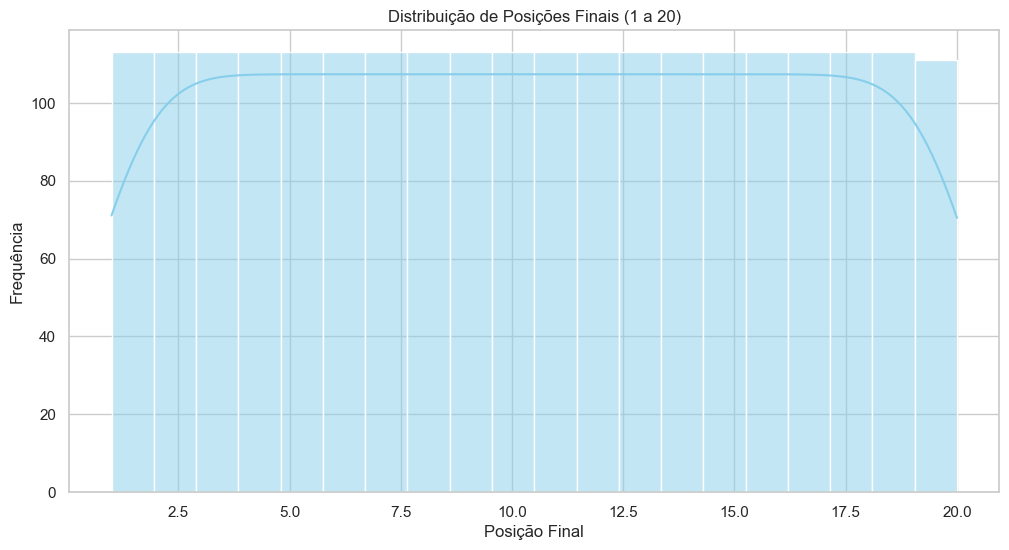

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(df['final_position'], bins=20, kde=True, color='skyblue')
plt.title('Distribuição de Posições Finais (1 a 20)')
plt.xlabel('Posição Final')
plt.ylabel('Frequência')
plt.show()

A imagem demonstra que o dataset está completo e equilibrado, sem "buracos", ou seja, dados irregulares 

O gráfico mostra uma correlação positiva entre a posição de largada e a posição final. Quanto menor a posição de largada, temos uma posição final consequentemente menor, também.
A bola azul, na posição 1,1 por exemplo que tem uma tonalidade mais forte, indica que muitos pilotos chegaram no resultado de largar em 1o e chegar em 1o 

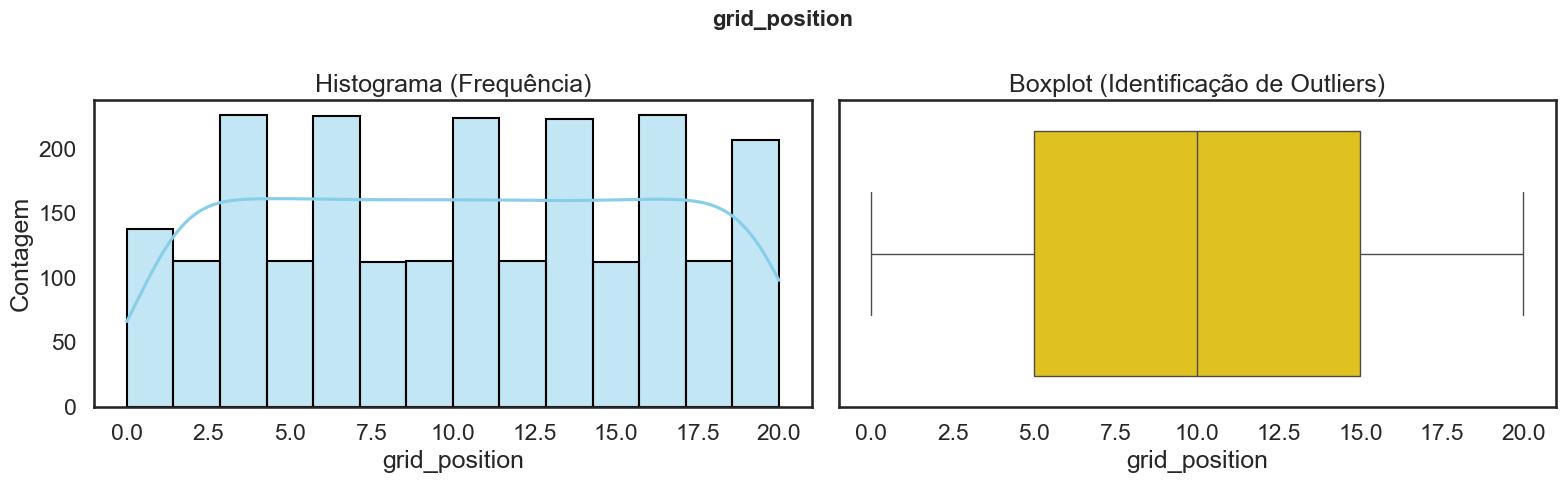

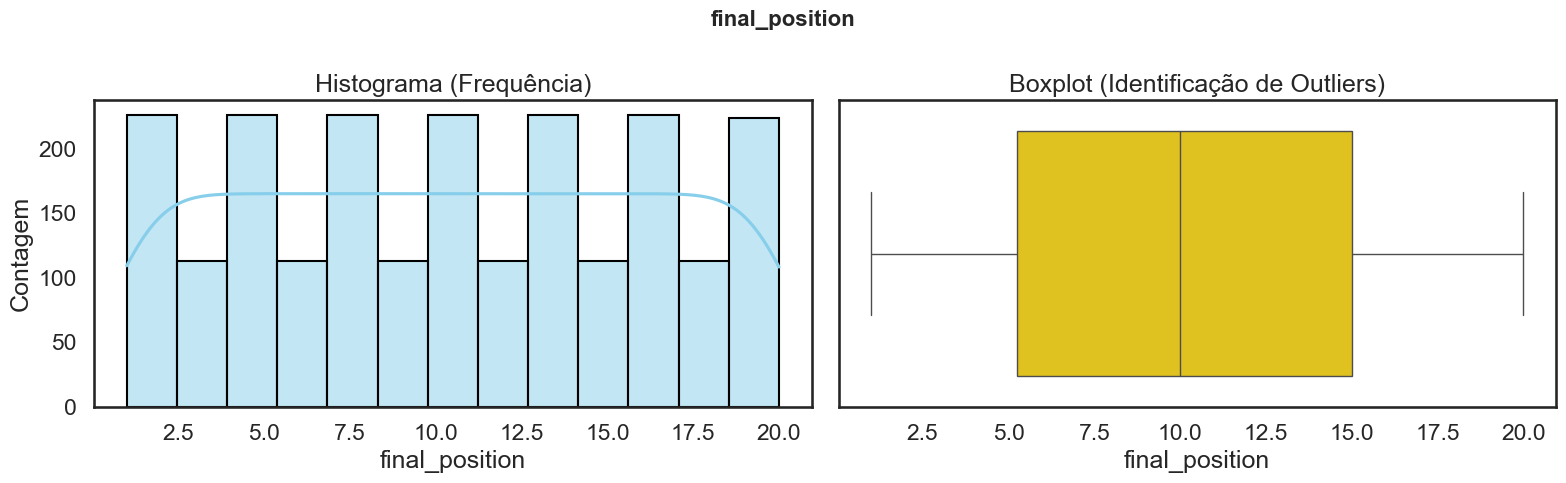

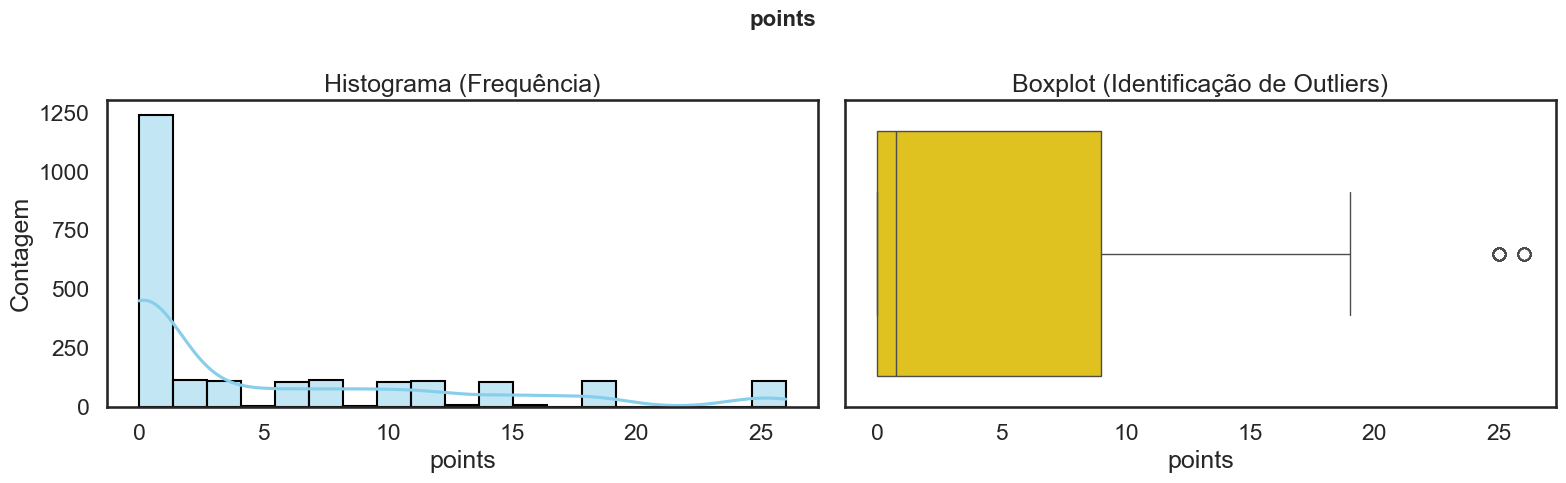

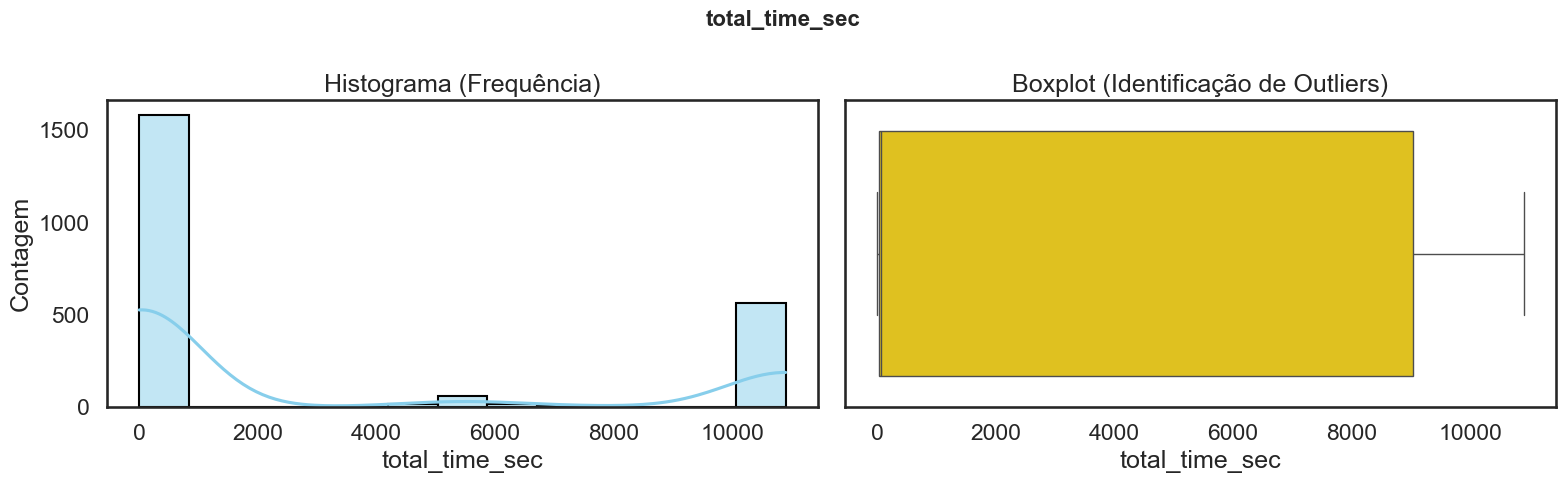

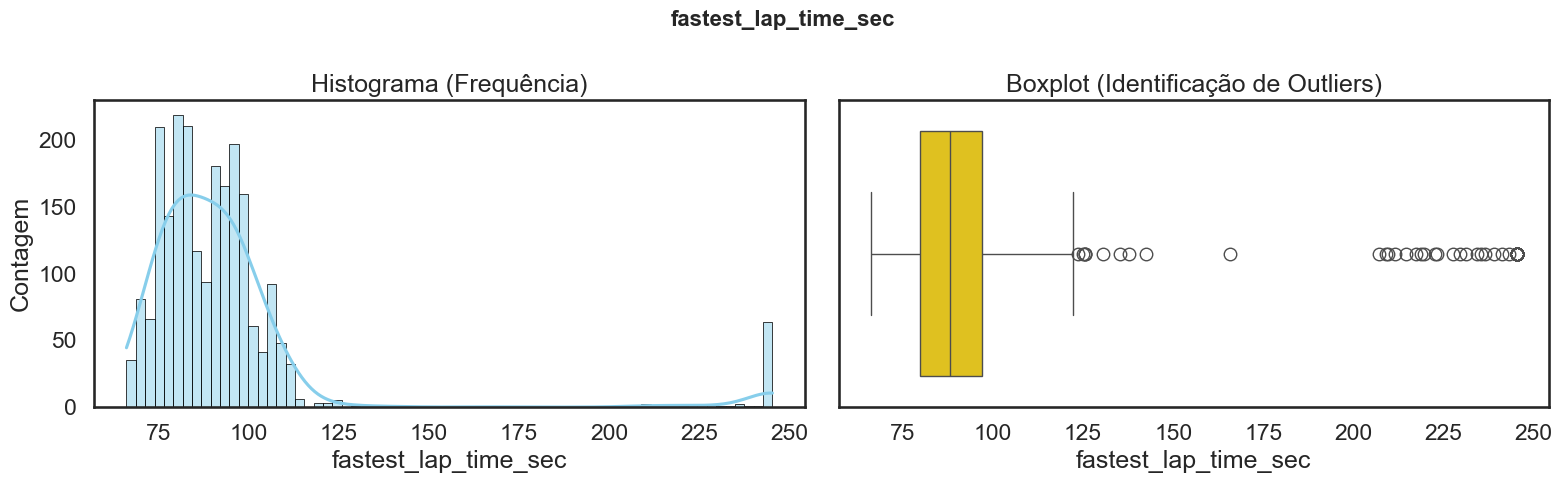

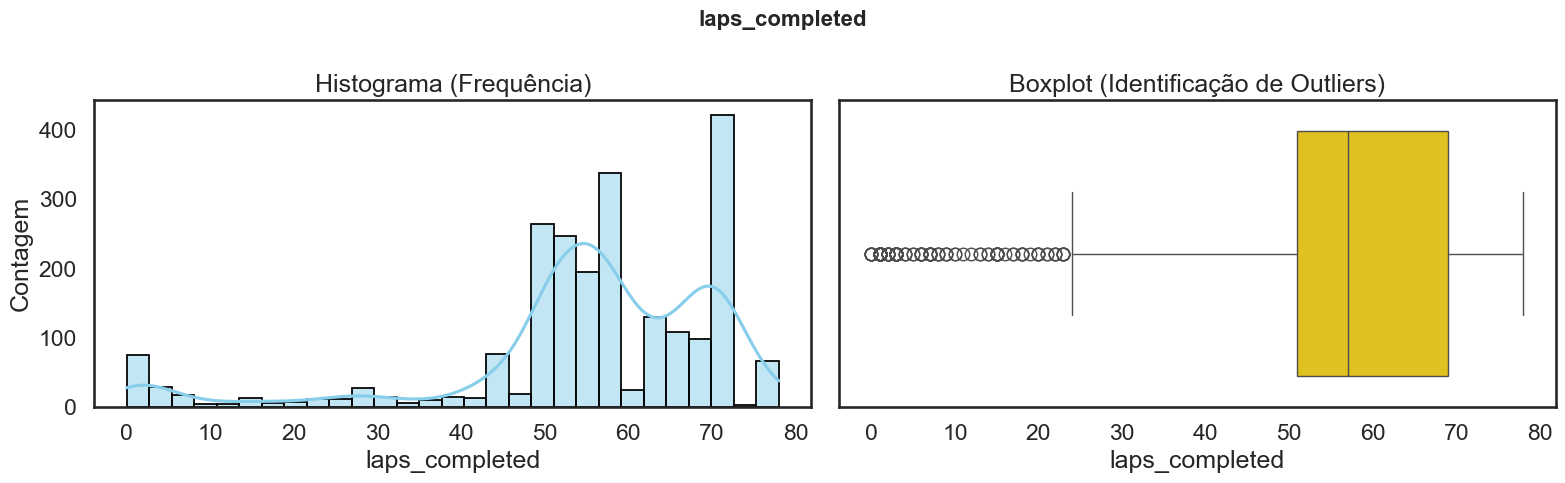

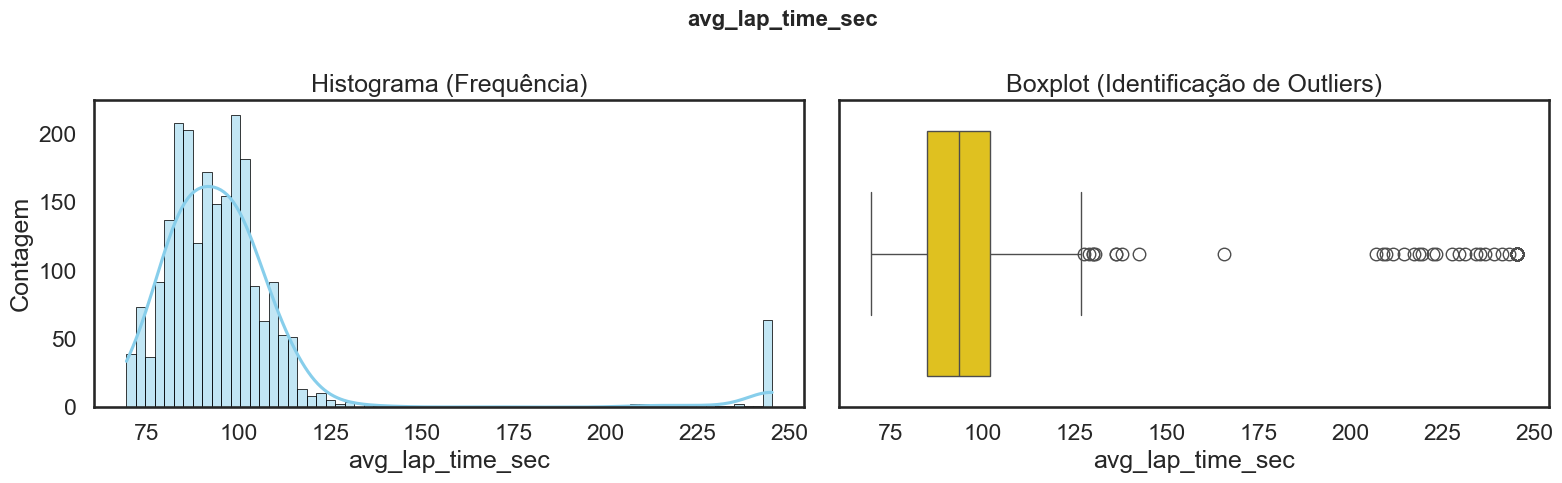

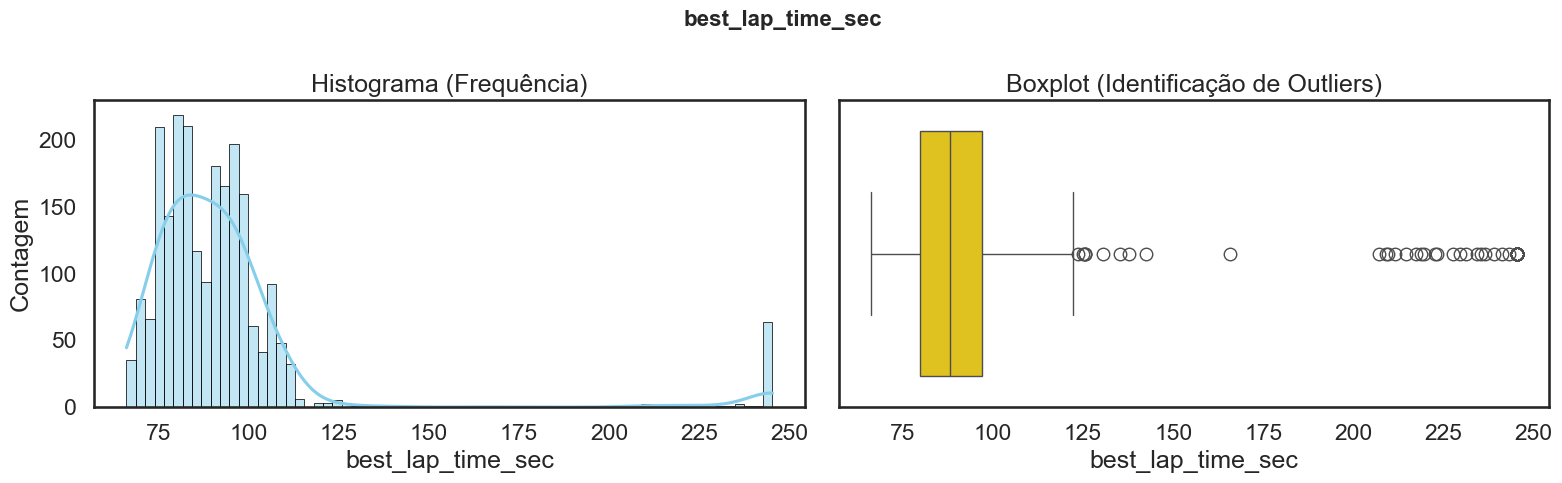

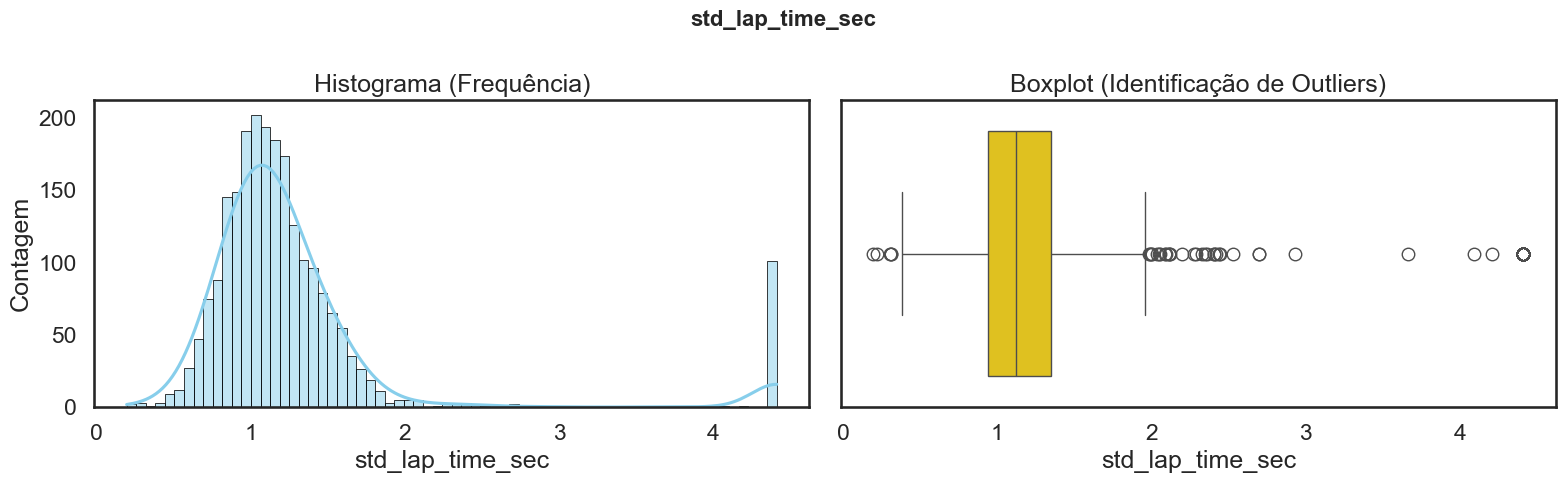

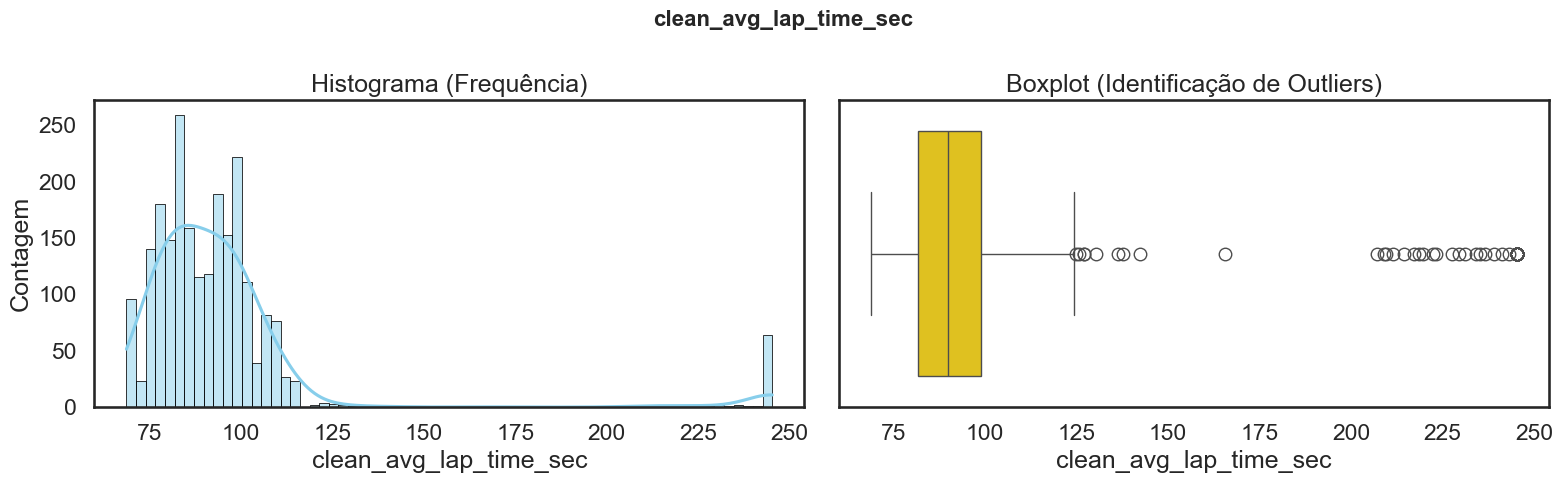

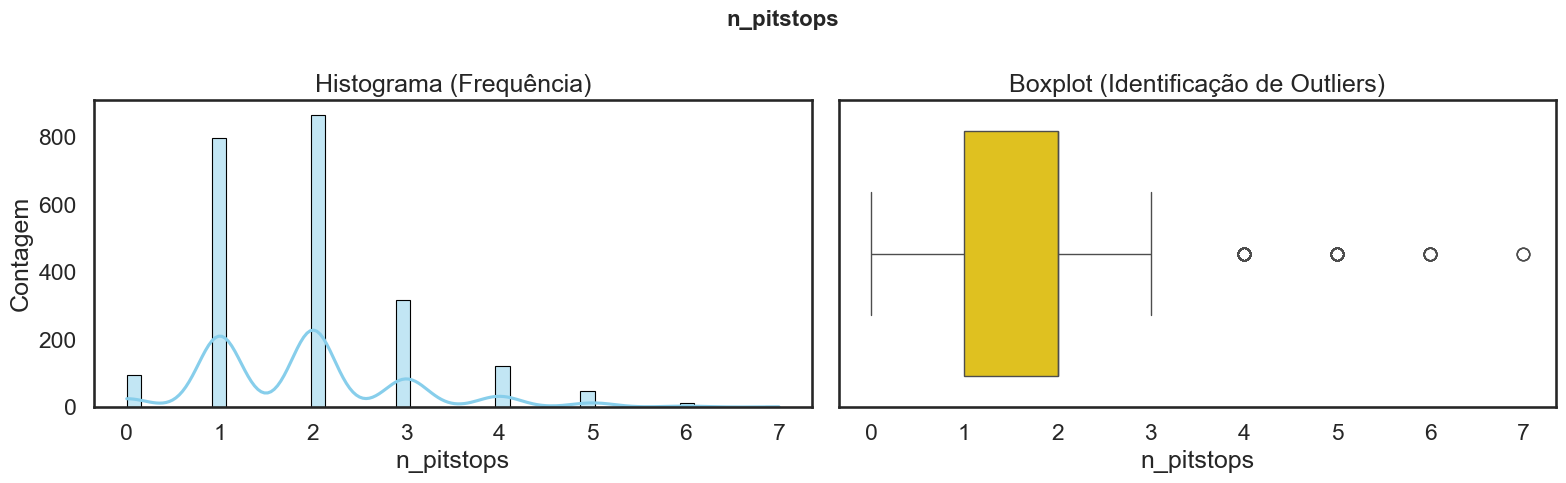

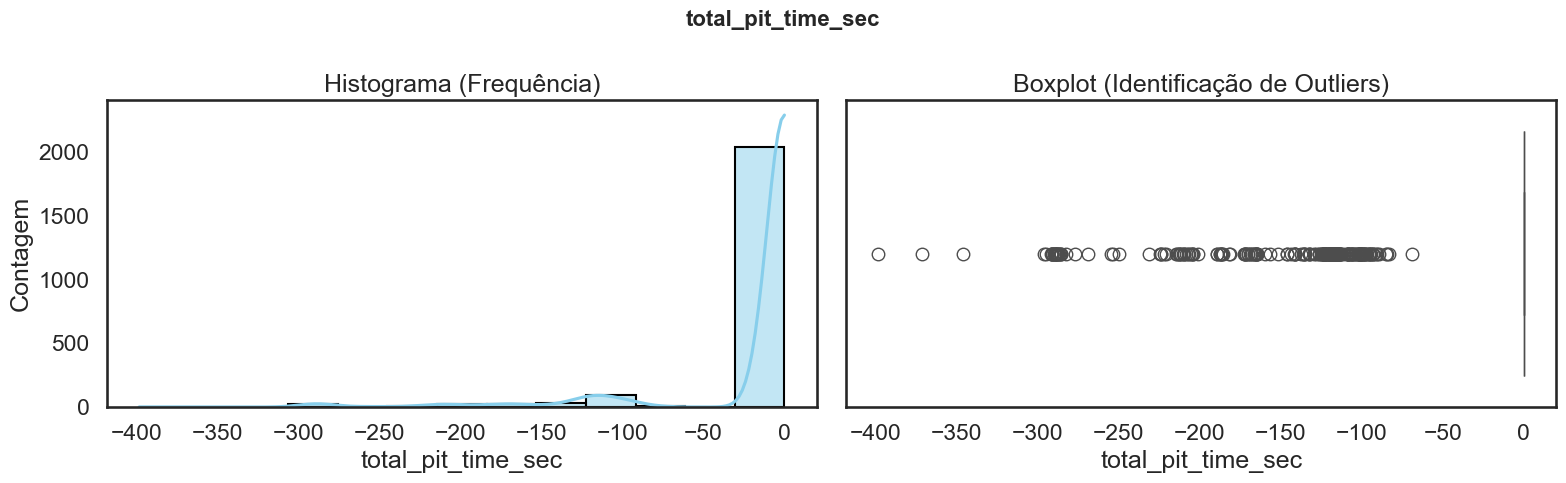

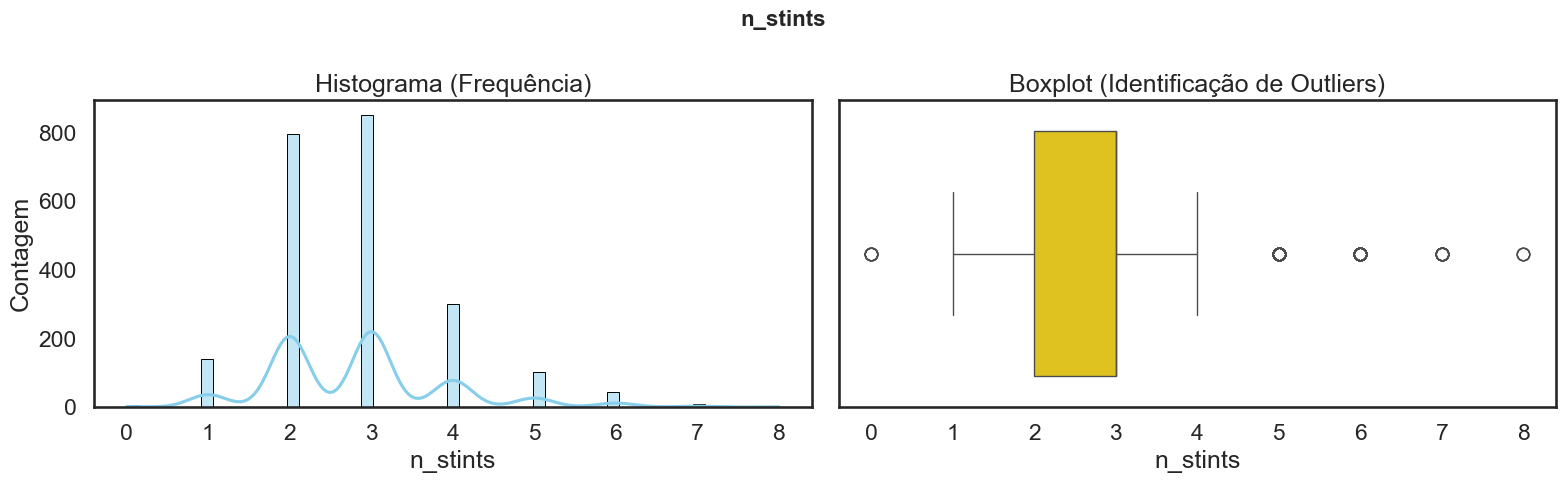

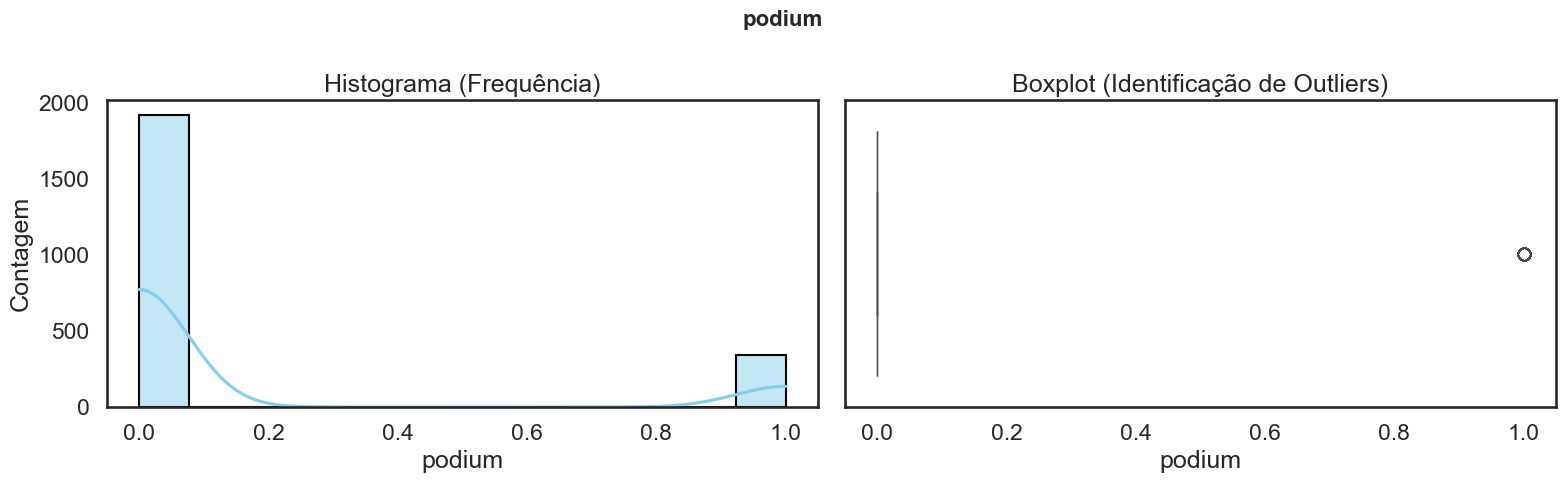

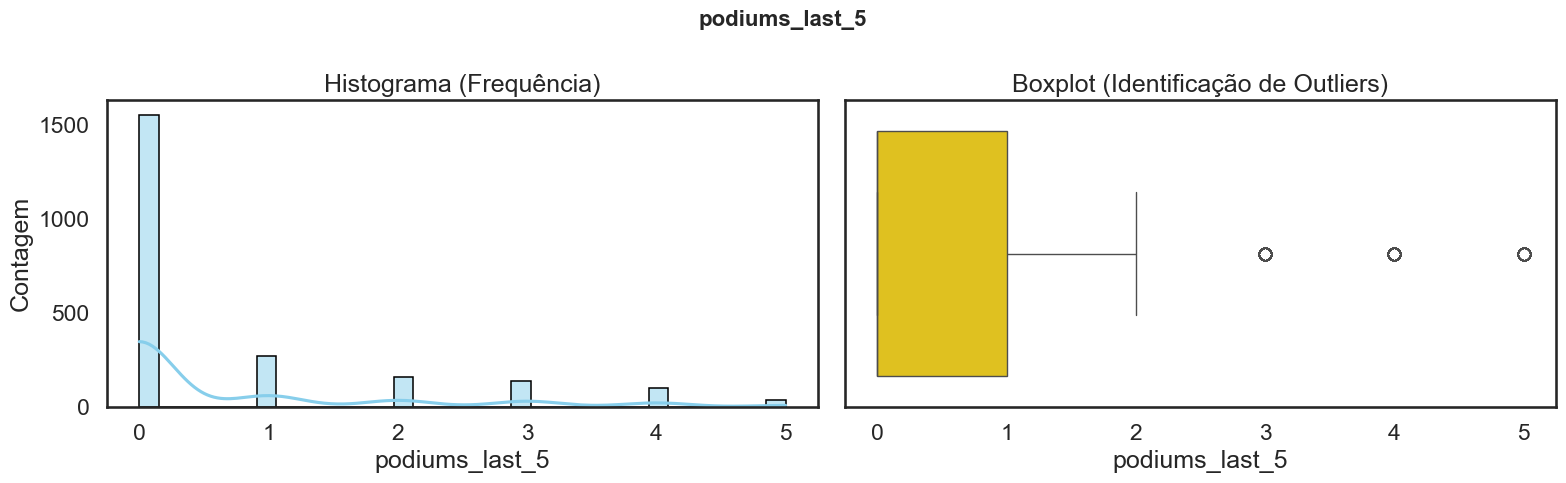

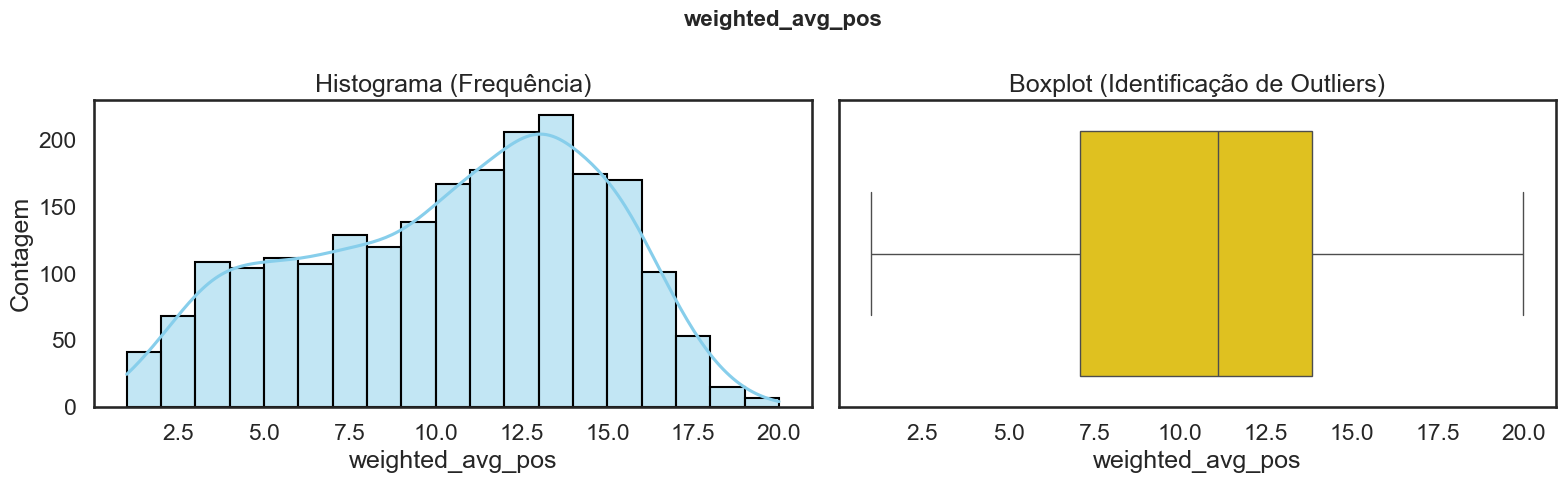

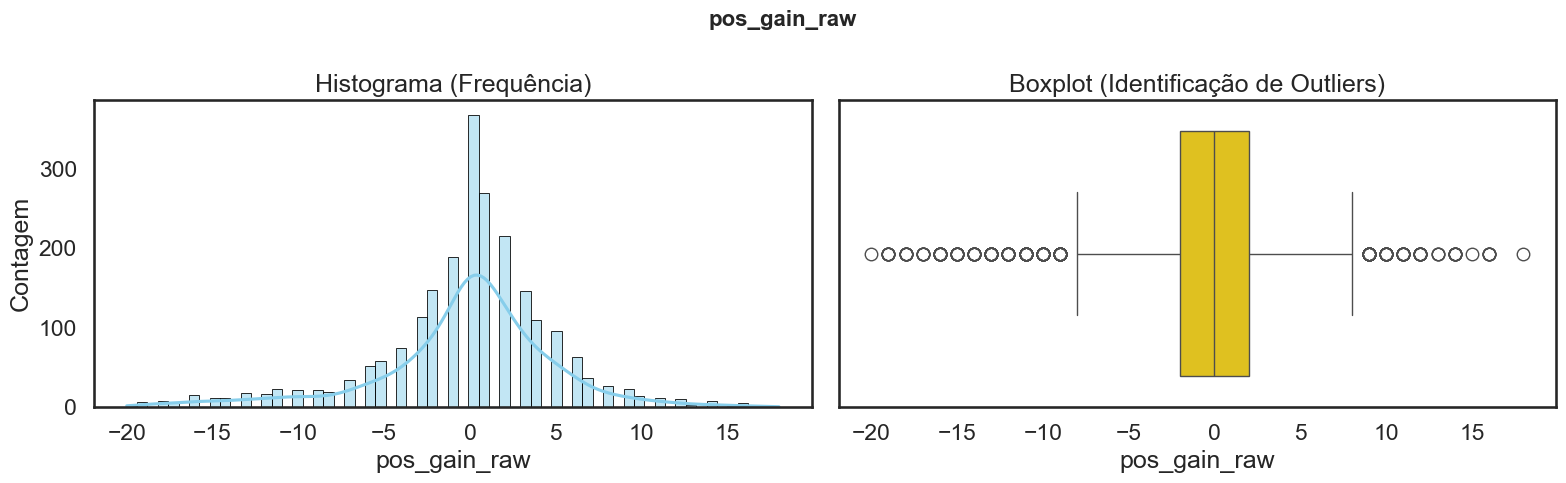

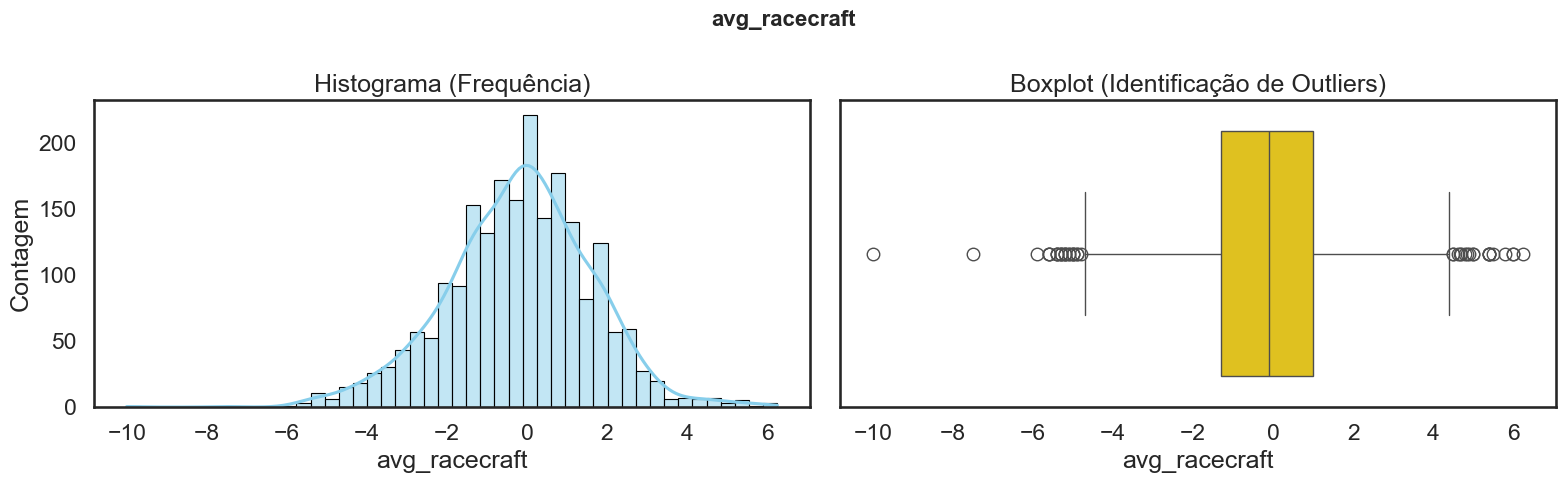

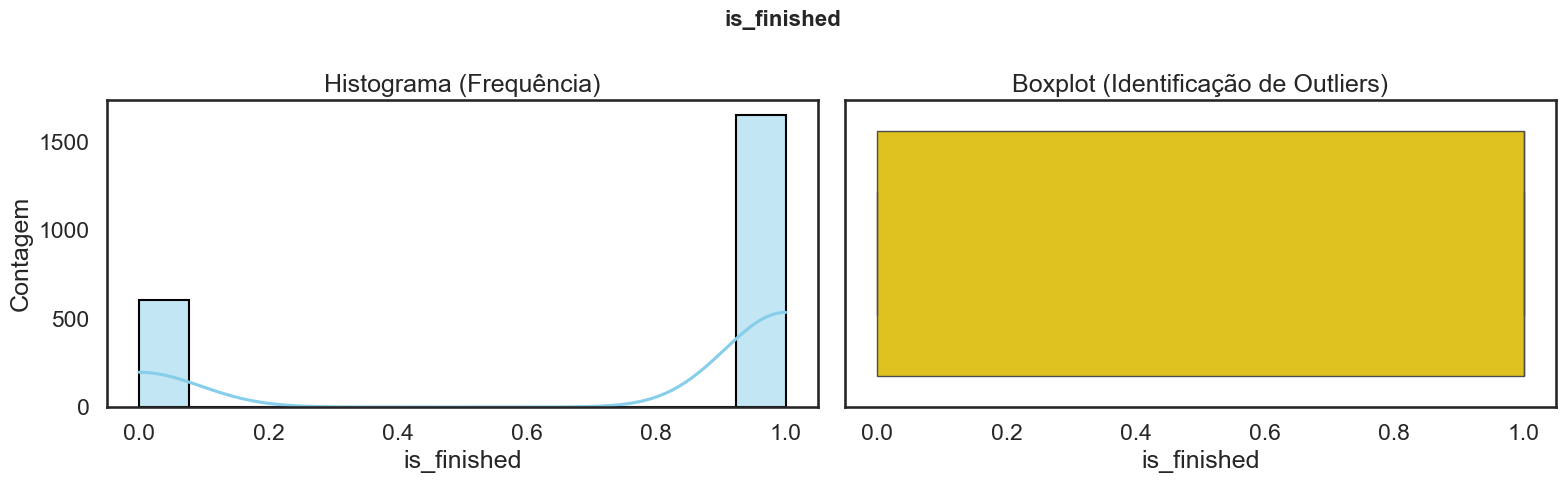

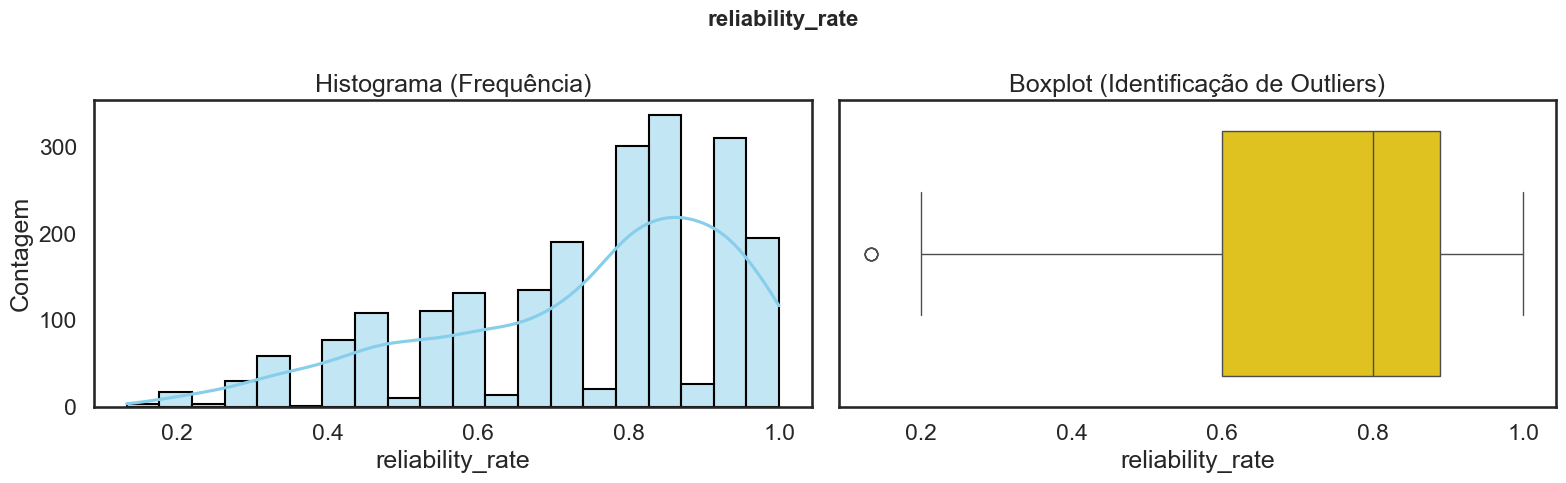

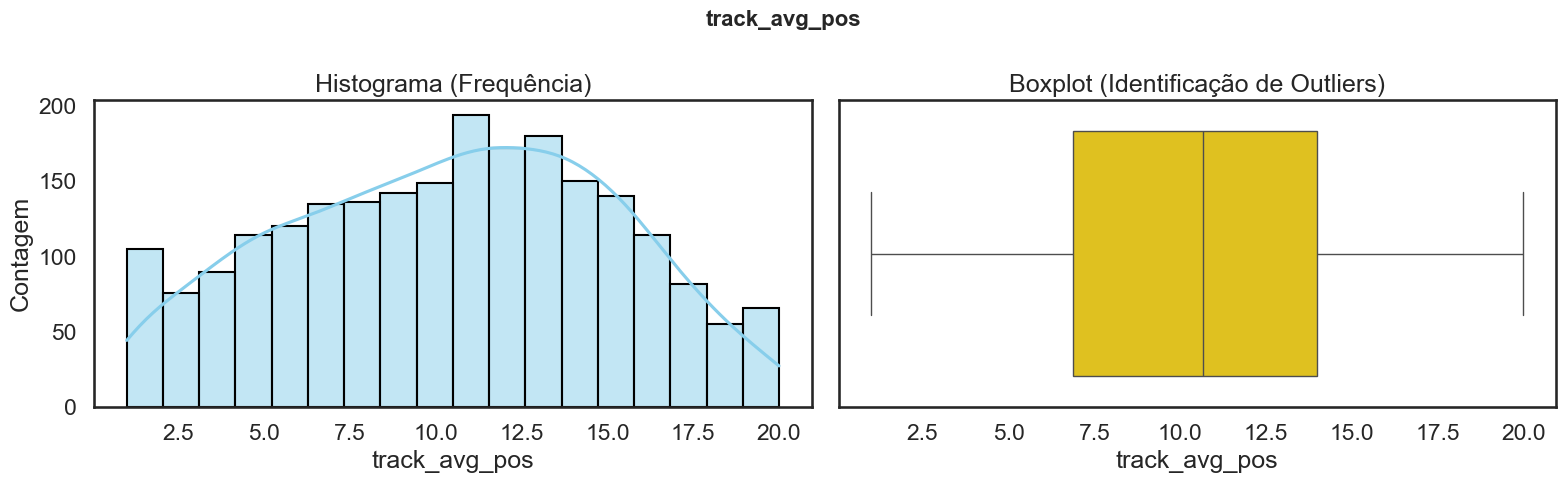

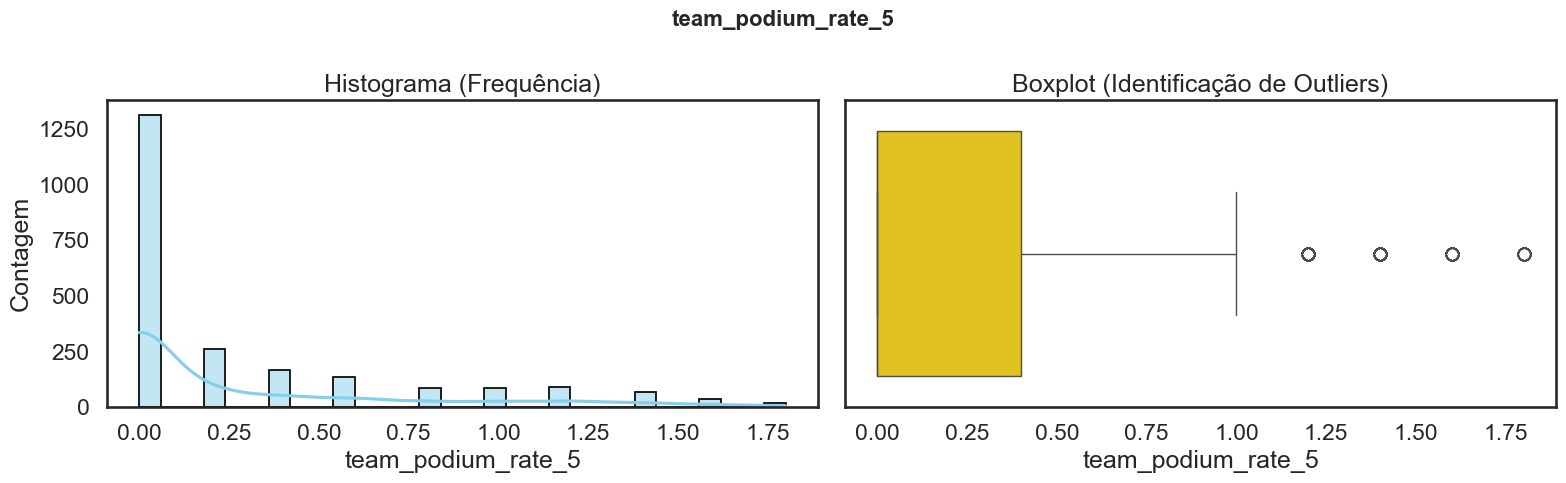

In [78]:
# Seleciona apenas colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

cols_to_ignore = ['season', 'round', 'driver_number', 'driver_code'] 
numeric_cols = [c for c in numeric_cols if c not in cols_to_ignore]

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Título Geral da Linha
    fig.suptitle(f'{col}', fontsize=16, weight='bold')
    
    # GRÁFICO 1: Histograma (Distribuição)
    # kde=True adiciona a linha suave da densidade
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title('Histograma (Frequência)')
    axes[0].set_ylabel('Contagem')
    
    # GRÁFICO 2: Boxplot (Outliers)
    # Mostra Mediana, Quartis e Pontos fora da curva
    sns.boxplot(data=df, x=col, ax=axes[1], color='gold')
    axes[1].set_title('Boxplot (Identificação de Outliers)')
    
    plt.tight_layout()
    plt.show()

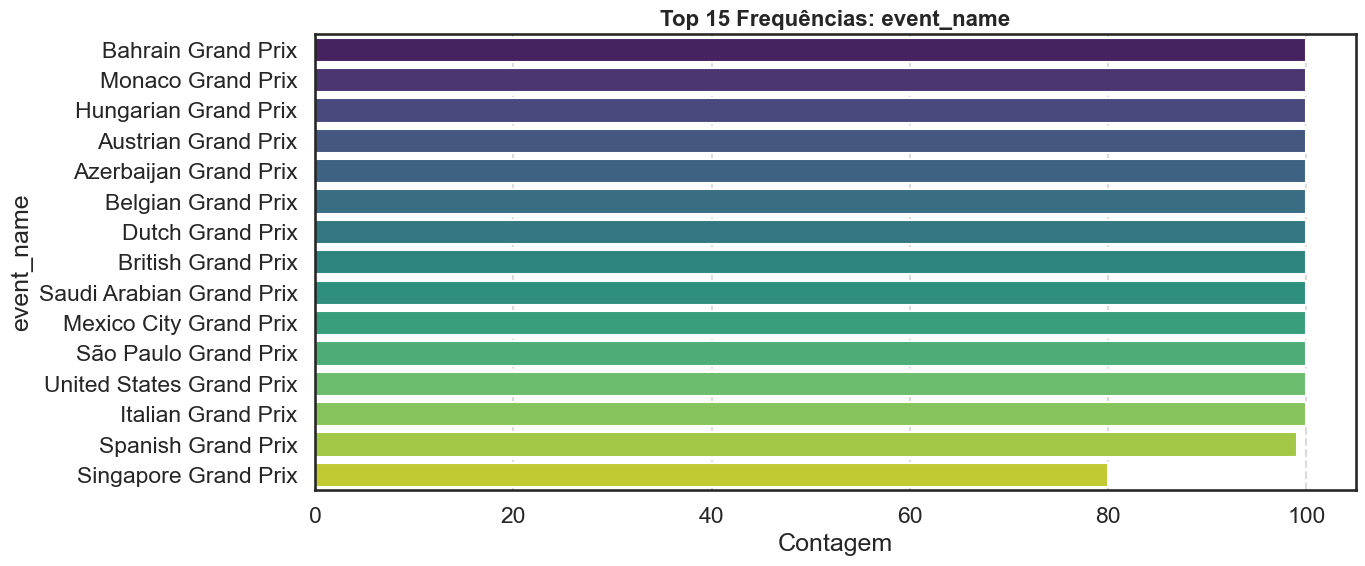

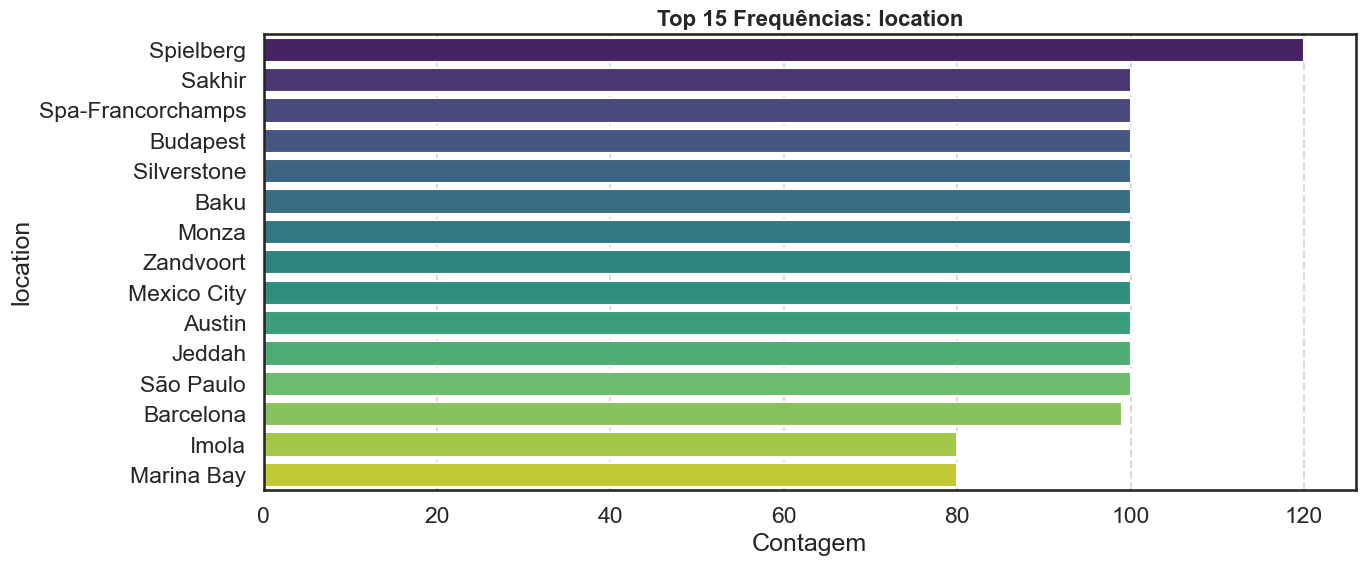

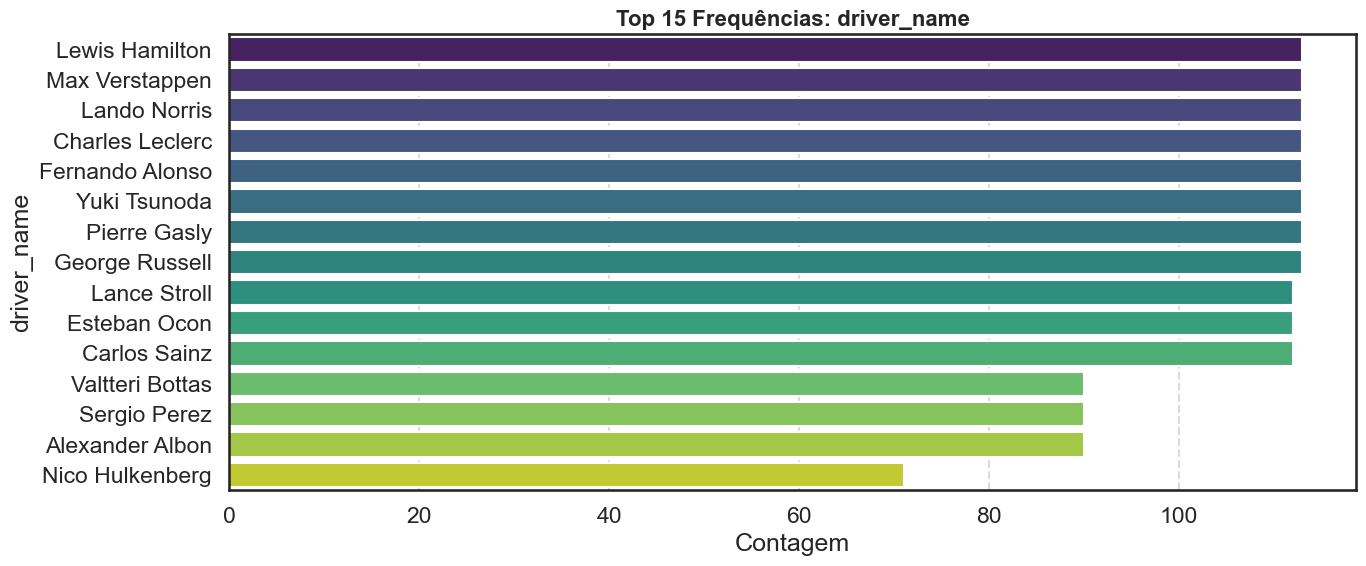

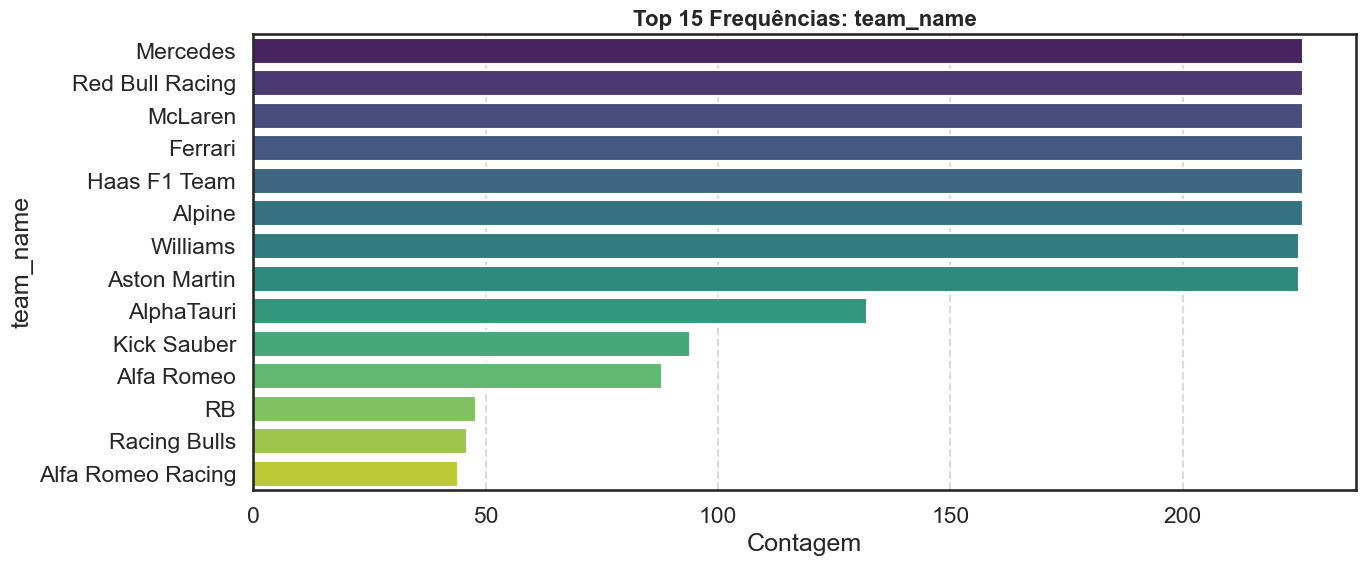

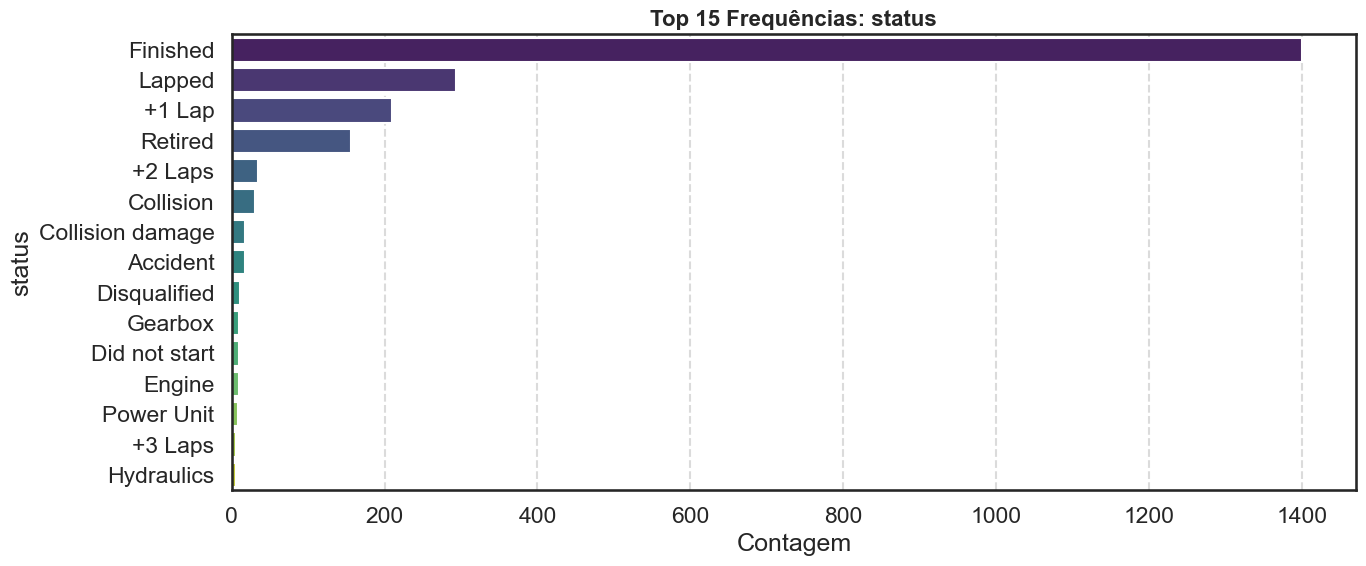

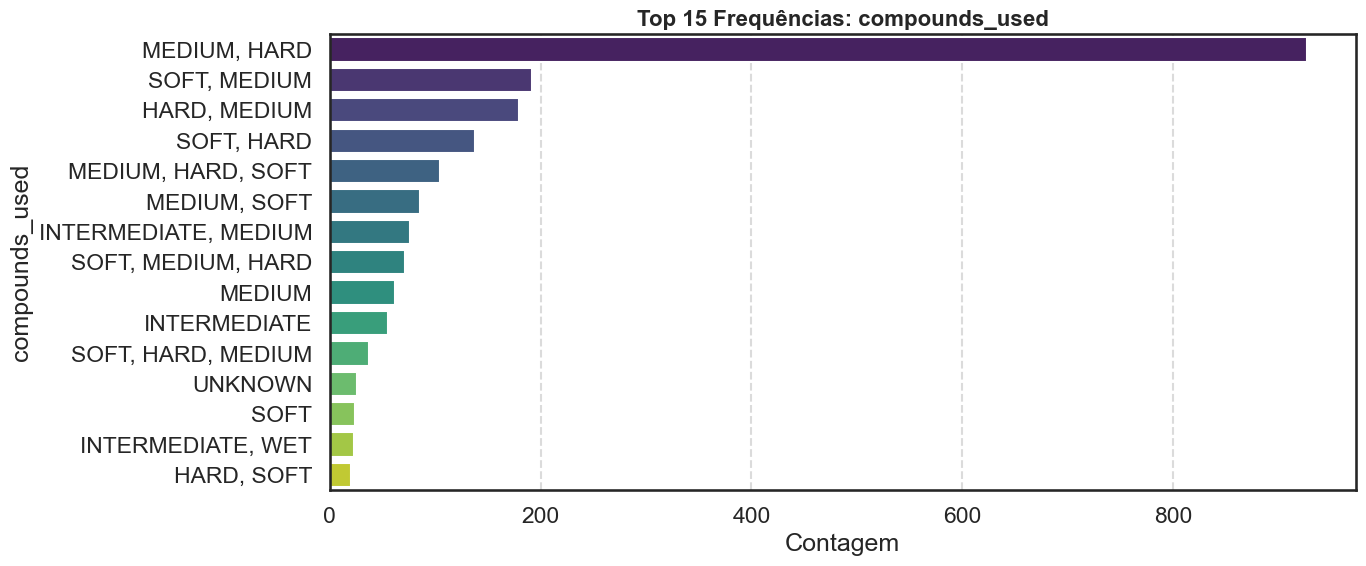

In [82]:
# ============================================================================
# 2. ANÁLISE DE VARIÁVEIS CATEGÓRICAS (Top Frequências)
# ==============================================================================
# Seleciona colunas de texto/objeto
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

cat_cols = [c for c in cat_cols if c not in ['event_date', 'url']]

for col in cat_cols:
    plt.figure(figsize=(14, 6))
    
    # Contar frequências
    top_counts = df[col].value_counts().head(15) # Pega apenas os Top 15 para não poluir
    
    sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis', hue=top_counts.index)
    
    plt.title(f'Top 15 Frequências: {col}', fontsize=16, weight='bold')
    plt.xlabel('Contagem')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

### Feature Engineering

As variáveis atuais capturadas dão uma noção da perfomance intra-corrida, sem olhar para o que ocorreu em corrida anterior 

In [20]:
grp_driver = df.groupby('driver_code')

In [21]:
# Criação da variável binária de pódio (Target)
df['podium'] = df['final_position'].apply(lambda x: 1 if x <= 3 else 0)

In [22]:
# Histórico de Pódios (Momentum)
# Quantas vezes o piloto subiu ao pódio nas últimas 5 corridas
# "Inércia de vitória" > pilotos em sequência positiva tendem a manter bom desempenho
df['podiums_last_5'] = df.groupby('driver_code')['podium'].transform(
    lambda x: x.shift(1).rolling(window=5).sum()
).fillna(0)

In [72]:
team_stats = df.groupby(['season', 'round', 'team_name'])['podium'].sum().reset_index()

# Calculamos a média móvel dos pódios da equipe nas últimas 5 corridas
# Atenção: Shift(1) para garantir que só usamos dados do PASSADO
team_stats['team_podium_rate_5'] = team_stats.groupby('team_name')['podium'].transform(
    lambda x: x.shift(1).rolling(window=5).mean()
).fillna(0)

# 2. MERGE COM O DATAFRAME PRINCIPAL
if 'team_podium_rate_5' not in df.columns:
    df = df.merge(team_stats[['season', 'round', 'team_name', 'team_podium_rate_5']], 
                  on=['season', 'round', 'team_name'], 
                  how='left')
    print("Coluna 'team_podium_rate_5' calculada e adicionada com sucesso.")

Coluna 'team_podium_rate_5' calculada e adicionada com sucesso.


In [24]:
# Média da posição final, com um peso exponencial
# Dá mais importância ao desempenho nas últimas 2 corridas que ao desempenho no início da temporada
# Permete detectar mudanças de ritmo
df['weighted_avg_pos'] = grp_driver['final_position'].transform(
    lambda x: x.ewm(span=5, adjust=False).mean().shift(1)
)

In [25]:
# Habilidade de corrida
# Mede a distância histórica entre a posição de largada e a posição final
# Valores positivos > pilotos bons mesmo largando atrás
# Valores negativos > pilotos perdem rendimento durante a prova
df['pos_gain_raw'] = df['grid_position'] - df['final_position']
df['avg_racecraft'] = grp_driver['pos_gain_raw'].transform(
    lambda x: x.rolling(window=10, min_periods=3).mean().shift(1)
)

In [26]:
# Taxa de Confiabilidade
# Porcentagem de corridas que o piloto terminou (sem abandonar/acidentes) nas últimas 15 provas
# Penaliza pilotos/carros instáveis
# Binário: 1 se terminou a corrida (usado para confiabilidade)
valid_finish = ['Finished', '+1 Lap', '+2 Laps', '+3 Laps']
df['is_finished'] = df['status'].apply(lambda x: 1 if str(x) in valid_finish else 0)

df['reliability_rate'] = grp_driver['is_finished'].transform(
    lambda x: x.rolling(window=15, min_periods=5).mean().shift(1)
)

In [27]:
# Especialista de pista
# Média histórica da posição final do piloto em um circuito específico em anos anteriores
# Afinidade do piloto com o track
# Se o piloto nunca correu na pista, é preenchido com a média ponderada geral
df['track_avg_pos'] = df.groupby(['driver_code', 'event_name'])['final_position'].transform(
  lambda x: x.expanding().mean().shift(1)
)
# Fallback: Se nunca correu na pista, usa a média ponderada atual
df['track_avg_pos'] = df['track_avg_pos'].fillna(df['weighted_avg_pos'])

### EDA

In [28]:
df.columns

Index(['season', 'round', 'event_name', 'location', 'event_date',
       'driver_code', 'driver_number', 'driver_name', 'team_name',
       'grid_position', 'final_position', 'status', 'points', 'total_time_sec',
       'fastest_lap_time_sec', 'laps_completed', 'avg_lap_time_sec',
       'best_lap_time_sec', 'std_lap_time_sec', 'clean_avg_lap_time_sec',
       'n_pitstops', 'total_pit_time_sec', 'n_stints', 'compounds_used',
       'podium', 'podiums_last_5', 'weighted_avg_pos', 'pos_gain_raw',
       'avg_racecraft', 'is_finished', 'reliability_rate', 'track_avg_pos'],
      dtype='object')

In [65]:
df.head()

,season,round,event_name,location,event_date,driver_code,driver_number,driver_name,team_name,grid_position,...,compounds_used,podium,podiums_last_5,weighted_avg_pos,pos_gain_raw,avg_racecraft,is_finished,reliability_rate,track_avg_pos,Grid_Cat
0,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,44,44,Lewis Hamilton,Mercedes,2.0,...,"MEDIUM, HARD",1,0.0,NaN,1.0,NaN,1,NaN,NaN,Top 3
1,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,33,33,Max Verstappen,Red Bull Racing,1.0,...,"MEDIUM, HARD",1,0.0,NaN,-1.0,NaN,1,NaN,NaN,Top 3
2,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,77,77,Valtteri Bottas,Mercedes,3.0,...,"MEDIUM, HARD",1,0.0,NaN,0.0,NaN,1,NaN,NaN,Top 3
3,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,4,4,Lando Norris,McLaren,7.0,...,"SOFT, MEDIUM, HARD",0,0.0,NaN,3.0,NaN,1,NaN,NaN,P7-P10
4,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,11,11,Sergio Perez,Red Bull Racing,0.0,...,"MEDIUM, HARD",0,0.0,NaN,-5.0,NaN,1,NaN,NaN,NaN


In [29]:
df.tail(20)

,season,round,event_name,location,event_date,driver_code,driver_number,driver_name,team_name,grid_position,...,n_stints,compounds_used,podium,podiums_last_5,weighted_avg_pos,pos_gain_raw,avg_racecraft,is_finished,reliability_rate,track_avg_pos
2238,2025,23,Qatar Grand Prix,Lusail,2025-11-30,1,1,Max Verstappen,Red Bull Racing,3.0,...,3.0,"MEDIUM, HARD",1,5.0,2.069943,2.0,1.9,1,0.933333,1.000000
2239,2025,23,Qatar Grand Prix,Lusail,2025-11-30,81,81,Oscar Piastri,McLaren,1.0,...,3.0,"MEDIUM, HARD",1,0.0,10.335717,-1.0,-2.4,1,0.866667,2.500000
2240,2025,23,Qatar Grand Prix,Lusail,2025-11-30,55,55,Carlos Sainz,Williams,7.0,...,3.0,"MEDIUM, HARD",1,0.0,10.983334,4.0,-1.3,1,0.533333,11.000000
2241,2025,23,Qatar Grand Prix,Lusail,2025-11-30,4,4,Lando Norris,McLaren,2.0,...,3.0,"MEDIUM, HARD",0,4.0,7.912271,-2.0,-3.1,1,0.800000,7.333333
2242,2025,23,Qatar Grand Prix,Lusail,2025-11-30,12,12,Kimi Antonelli,Mercedes,5.0,...,3.0,"MEDIUM, HARD",0,2.0,5.215523,0.0,0.7,1,0.666667,5.215523
2243,2025,23,Qatar Grand Prix,Lusail,2025-11-30,63,63,George Russell,Mercedes,4.0,...,3.0,"MEDIUM, HARD",0,2.0,3.755415,-2.0,0.5,1,0.933333,8.333333
2244,2025,23,Qatar Grand Prix,Lusail,2025-11-30,14,14,Fernando Alonso,Aston Martin,8.0,...,3.0,"MEDIUM, HARD",0,0.0,12.638986,1.0,-1.8,1,0.733333,5.333333
2245,2025,23,Qatar Grand Prix,Lusail,2025-11-30,16,16,Charles Leclerc,Ferrari,10.0,...,3.0,"MEDIUM, HARD",0,2.0,7.630187,2.0,-2.5,1,0.866667,5.000000
2246,2025,23,Qatar Grand Prix,Lusail,2025-11-30,30,30,Liam Lawson,Racing Bulls,12.0,...,3.0,"MEDIUM, HARD",0,0.0,12.539320,3.0,-1.5,1,0.600000,14.000000
2247,2025,23,Qatar Grand Prix,Lusail,2025-11-30,22,22,Yuki Tsunoda,Red Bull Racing,15.0,...,3.0,"MEDIUM, HARD",0,0.0,12.289961,5.0,1.0,1,0.600000,13.666667


In [89]:
PALETA = {
    "olivewood": "#210706",
    "tuscan_red": "#891D1A",
    "slate_blue": "#5E657B",
    "creamy_biscotti": "#F1E6D2"
}

plt.rcParams['axes.facecolor']   = PALETA["creamy_biscotti"]
plt.rcParams['figure.facecolor'] = PALETA["creamy_biscotti"]
plt.rcParams['xtick.color']      = PALETA["olivewood"]
plt.rcParams['ytick.color']      = PALETA["olivewood"]
plt.rcParams['text.color']       = PALETA["olivewood"]
plt.rcParams['axes.labelcolor']  = PALETA["olivewood"]
plt.rcParams['axes.edgecolor']   = PALETA["olivewood"]

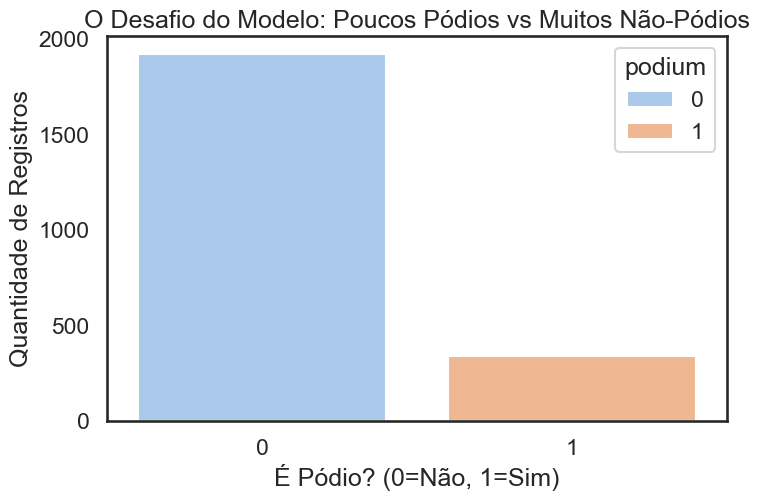

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='podium', data=df, palette='pastel', hue='podium')
plt.title('')
plt.xlabel('É Pódio? (0=Não, 1=Sim)')
plt.ylabel('Quantidade de Registros')
plt.show()

Classes desbalanceadas, na implementação do modelo precisam-se trabalhar estratégias para contornar o problema.

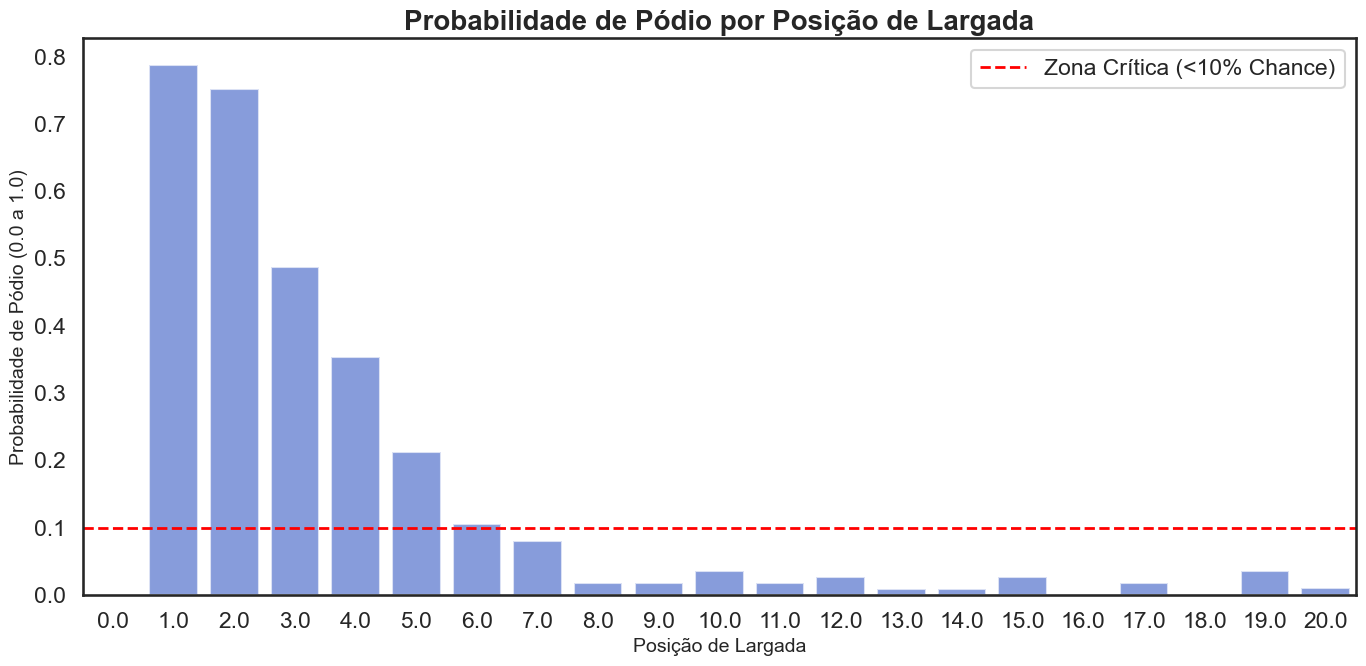

In [83]:
plt.figure(figsize=(14, 7))

# Calcula probabilidade de pódio por posição de largada
grid_prob = df.groupby('grid_position')['podium'].mean().reset_index()
grid_prob = grid_prob[grid_prob['grid_position'] <= 20] # Limitar ao grid normal

# Gráfico de Barras com Linha de Tendência
ax = sns.barplot(x='grid_position', y='podium', data=grid_prob, color='royalblue', alpha=0.7)

# Adicionar linha de corte de 10%
plt.axhline(y=0.10, color='red', linestyle='--', linewidth=2, label='Zona Crítica (<10% Chance)')

plt.title('Probabilidade de Pódio por Posição de Largada', fontsize=20, weight='bold')
plt.xlabel('Posição de Largada', fontsize=14)
plt.ylabel('Probabilidade de Pódio (0.0 a 1.0)', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Largar abaixo de P8 torna rara a possibilidade de pódio

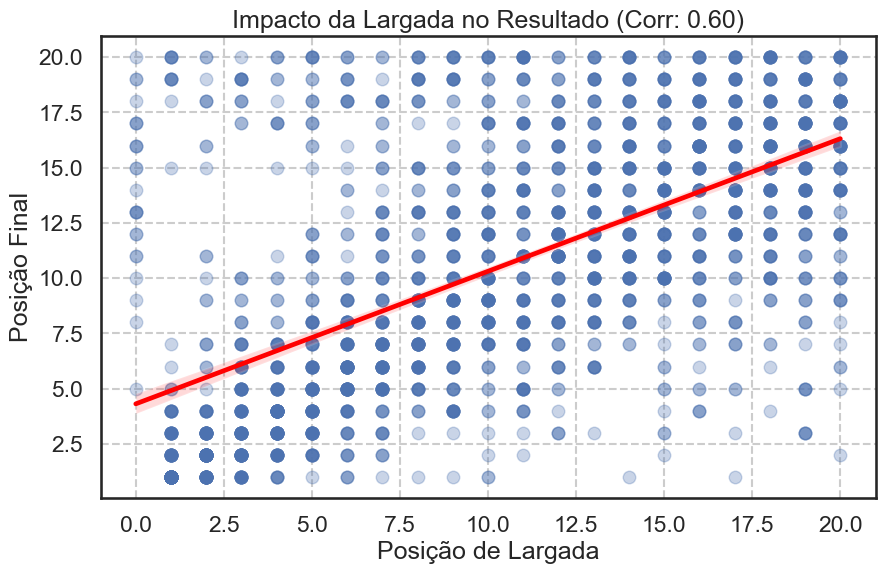

In [88]:
# Correlação Grid vs Final
corr = df['grid_position'].corr(df['final_position'])
# Visualização 2: Grid vs Final (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.regplot(x='grid_position', y='final_position', data=df, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Impacto da Largada no Resultado (Corr: {corr:.2f})')
plt.xlabel('Posição de Largada')
plt.ylabel('Posição Final')
plt.grid(True, linestyle='--')
plt.show()

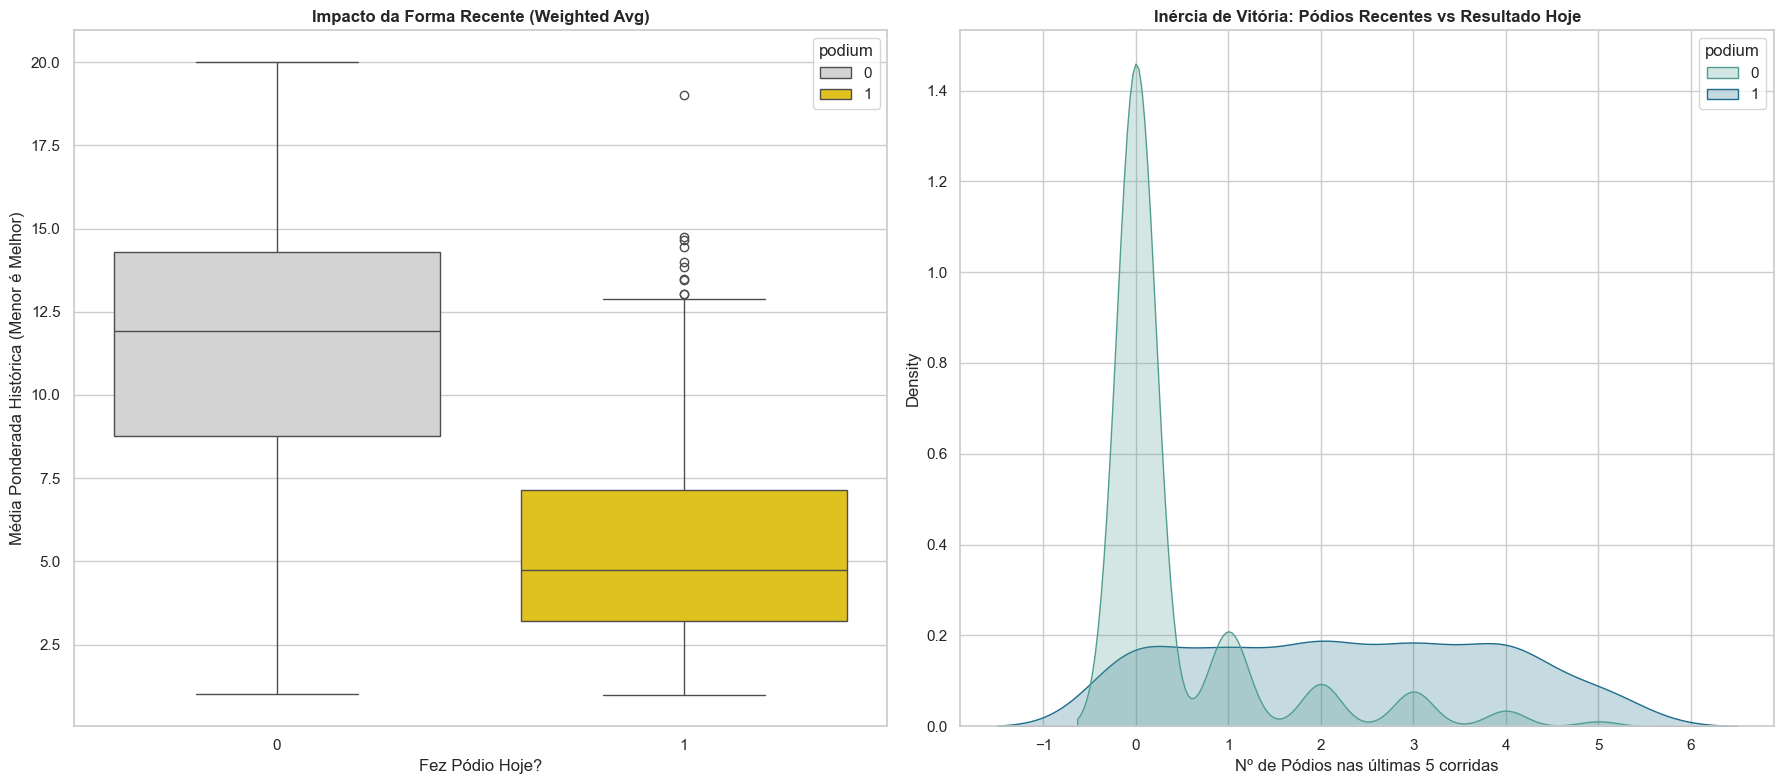

In [32]:
# Gráfico A: Boxplot de Forma Ponderada
fig, axes = plt.subplots(1, 2, figsize=(18, 8)) 
# Garantir que a coluna 'podium' é do tipo inteiro
df['podium'] = df['podium'].astype(int)

# Gráfico A: Boxplot de Forma Ponderada
sns.boxplot(x='podium', y='weighted_avg_pos', data=df, ax=axes[0], palette={0: "lightgray", 1: "gold"}, hue='podium')
axes[0].set_title('Impacto da Forma Recente (Weighted Avg)', weight='bold')
axes[0].set_xlabel('Fez Pódio Hoje?')
axes[0].set_ylabel('Média Ponderada Histórica (Menor é Melhor)')

# Gráfico B: Densidade de Pódios Recentes
sns.kdeplot(data=df, x='podiums_last_5', hue='podium', fill=True, common_norm=False, palette="crest", ax=axes[1])
axes[1].set_title('Inércia de Vitória: Pódios Recentes vs Resultado Hoje', weight='bold')
axes[1].set_xlabel('Nº de Pódios nas últimas 5 corridas')

plt.tight_layout()
plt.show()

Pilotos que fazem pódio (amarelo) têm uma média ponderada mais baixa e estão se saindo melhor nas corridas em comparação com quem não faz pódio (cinza)

Isso significa que os pilotos que fazem pódio têm uma média ponderada mais baixa, estão se saindo melhor nas corridas

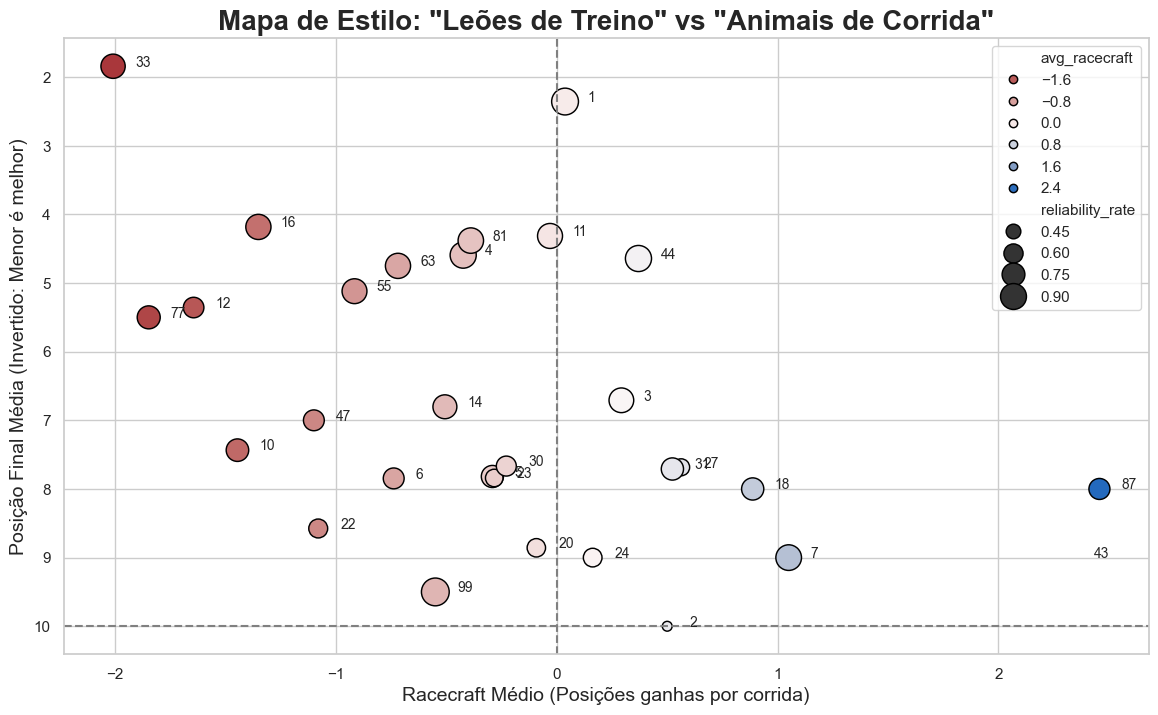

In [ ]:
plt.figure(figsize=(14, 8))

# Vamos focar apenas nos pilotos que pontuaram (Top 10) para limpar o gráfico
top_drivers = df[df['final_position'] <= 10]

# Scatter plot: Eixo X = Racecraft (Habilidade), Eixo Y = Posição Final Média
# Tamanho da bolha = Confiabilidade
sns.scatterplot(
    data=top_drivers.groupby('driver_code').mean(numeric_only=True).reset_index(),
    x='avg_racecraft', 
    y='final_position', 
    size='reliability_rate',
    sizes=(50, 400),
    hue='avg_racecraft',
    palette='vlag_r', # Vermelho (perde) -> Azul (ganha)
    edgecolor='black'
)

# Linhas de referência
plt.axvline(0, color='gray', linestyle='--')
plt.axhline(10, color='gray', linestyle='--')

# Adicionar nomes (Labels)
driver_stats = top_drivers.groupby('driver_code')[['avg_racecraft', 'final_position']].mean().reset_index()
for i in range(driver_stats.shape[0]):
    plt.text(
        driver_stats.avg_racecraft.iloc[i]+0.1, 
        driver_stats.final_position.iloc[i], 
        driver_stats.driver_code.iloc[i], 
        fontsize=10
    )

plt.title('Mapa de Estilo: "Leões de Treino" vs "Animais de Corrida"', fontsize=20, weight='bold')
plt.xlabel('Racecraft Médio (Posições ganhas por corrida)', fontsize=14)
plt.ylabel('Posição Final Média (Invertido: Menor é melhor)', fontsize=14)
plt.gca().invert_yaxis() # Inverter Y porque 1º lugar é "menor" que 10º

plt.show()

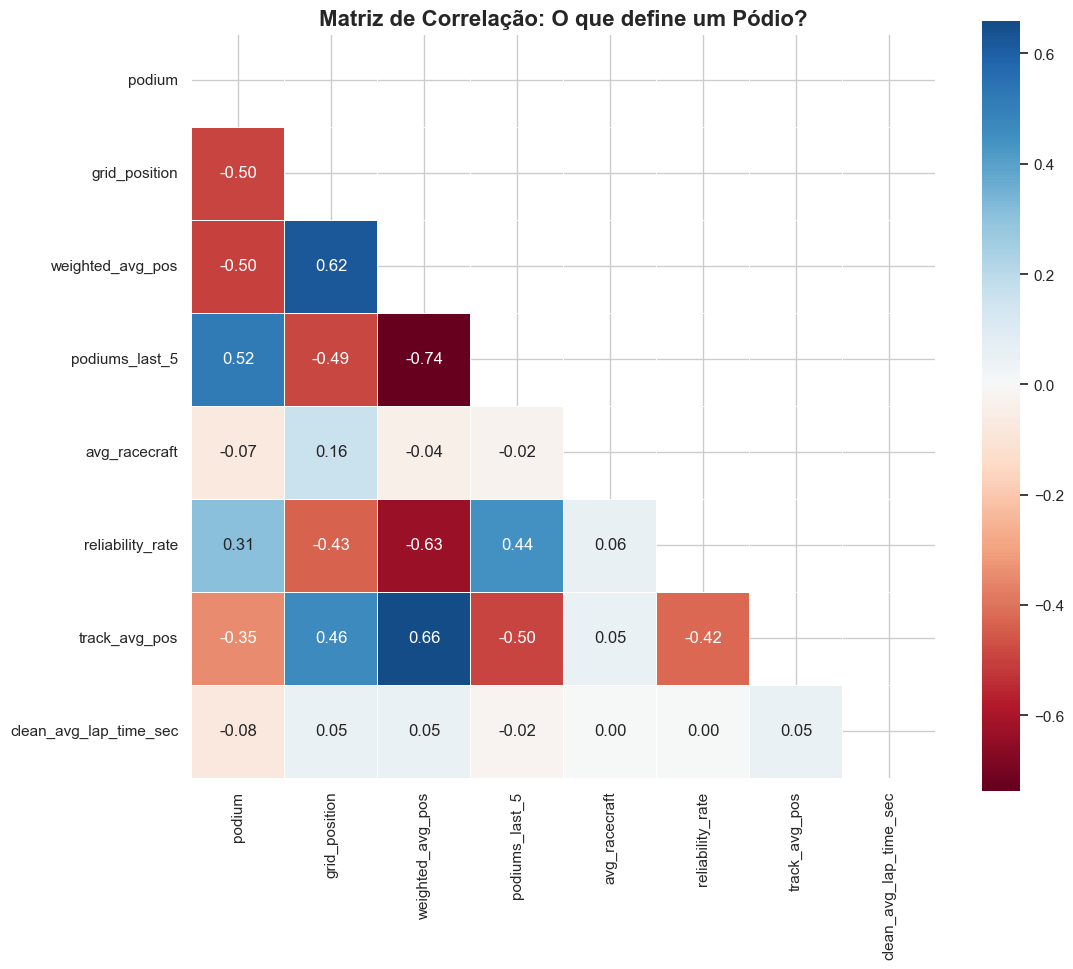

In [38]:
plt.figure(figsize=(12, 10))

# Selecionar apenas colunas numéricas de interesse
cols_corr = [
    'podium', 
    'grid_position', 
    'weighted_avg_pos', 
    'podiums_last_5', 
    'avg_racecraft', 
    'reliability_rate', 
    'track_avg_pos',
    'clean_avg_lap_time_sec' # Só para checar se tempo bruto ajuda (spoiler: não muito)
]

corr = df[cols_corr].corr()

# Máscara para ocultar a parte superior (duplicada)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu', center=0, square=True, linewidths=.5)
plt.title('Matriz de Correlação: O que define um Pódio?', fontsize=16, weight='bold')

plt.show()

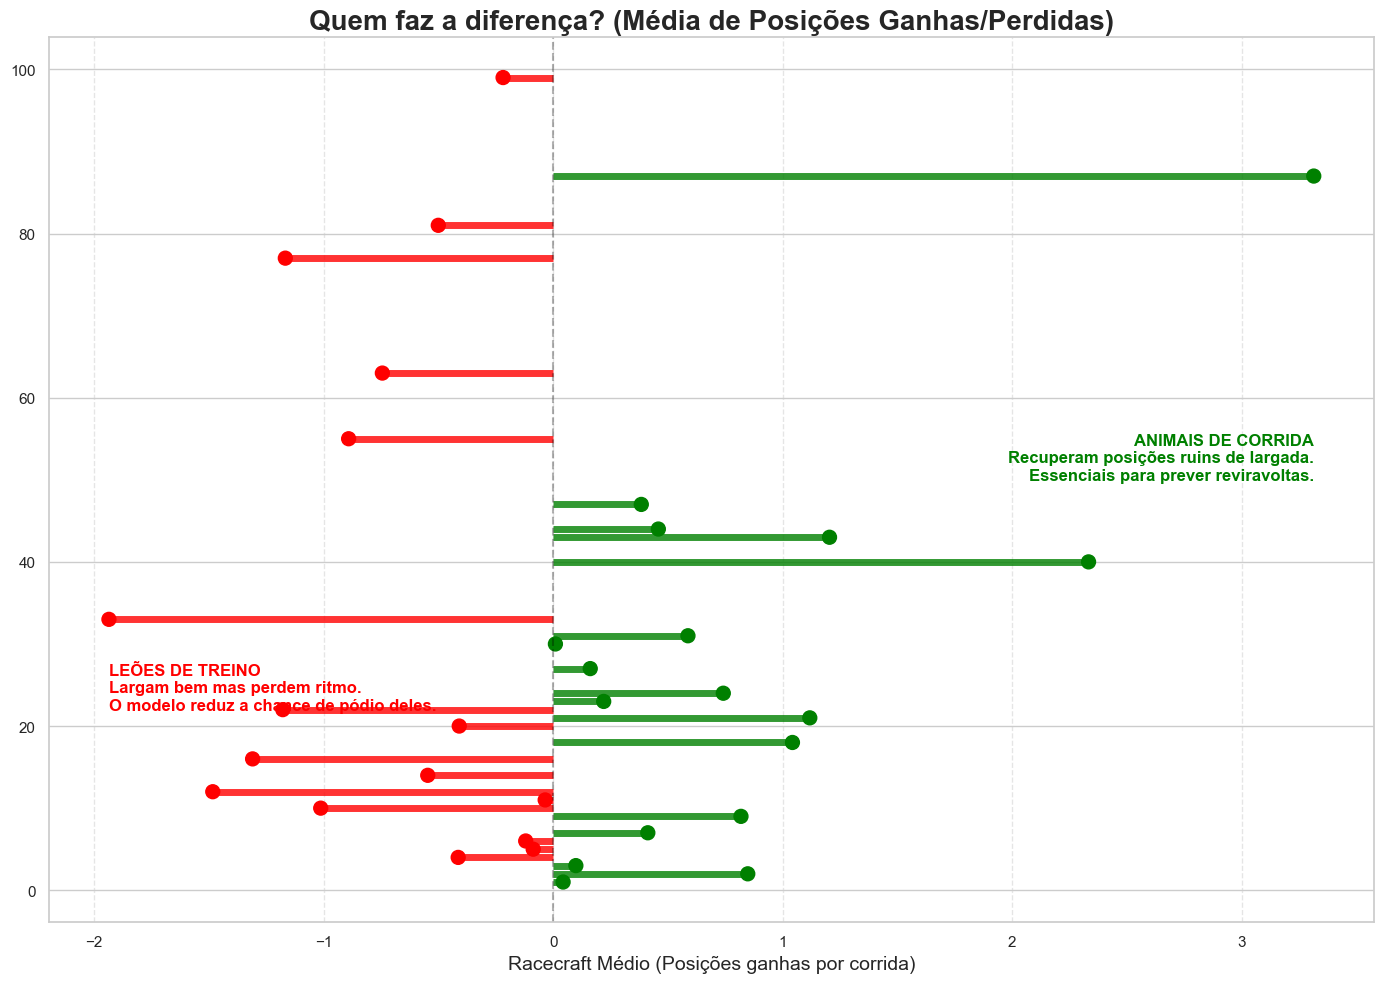

In [44]:
plt.figure(figsize=(14, 10))

# Calcular média de racecraft por piloto e ordenar
driver_skill = df.groupby('driver_code')['avg_racecraft'].mean().sort_values()
# Filtrar apenas pilotos ativos/relevantes (opcional, aqui pegamos todos)
colors = ['red' if x < 0 else 'green' for x in driver_skill.values]

# Gráfico de Barras Horizontal
plt.hlines(y=driver_skill.index, xmin=0, xmax=driver_skill.values, color=colors, alpha=0.8, linewidth=5)
plt.scatter(driver_skill.values, driver_skill.index, color=colors, s=100, alpha=1)

plt.title('Quem faz a diferença? (Média de Posições Ganhas/Perdidas)', fontsize=20, weight='bold')
plt.xlabel('Racecraft Médio (Posições ganhas por corrida)', fontsize=14)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Texto Explicativo
plt.text(driver_skill.max(), driver_skill.index[len(driver_skill)-3], 
         "ANIMAIS DE CORRIDA\nRecuperam posições ruins de largada.\nEssenciais para prever reviravoltas.", 
         color='green', ha='right', weight='bold')

plt.text(driver_skill.min(), driver_skill.index[3], 
         "LEÕES DE TREINO\nLargam bem mas perdem ritmo.\nO modelo reduz a chance de pódio deles.", 
         color='red', ha='left', weight='bold')

plt.tight_layout()
plt.show()

C:\Users\thzli\AppData\Local\Temp\ipykernel_5404\906720507.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='podium', y='weighted_avg_pos', data=plot_data, size=4, palette=["#95a5a6", "#f1c40f"])


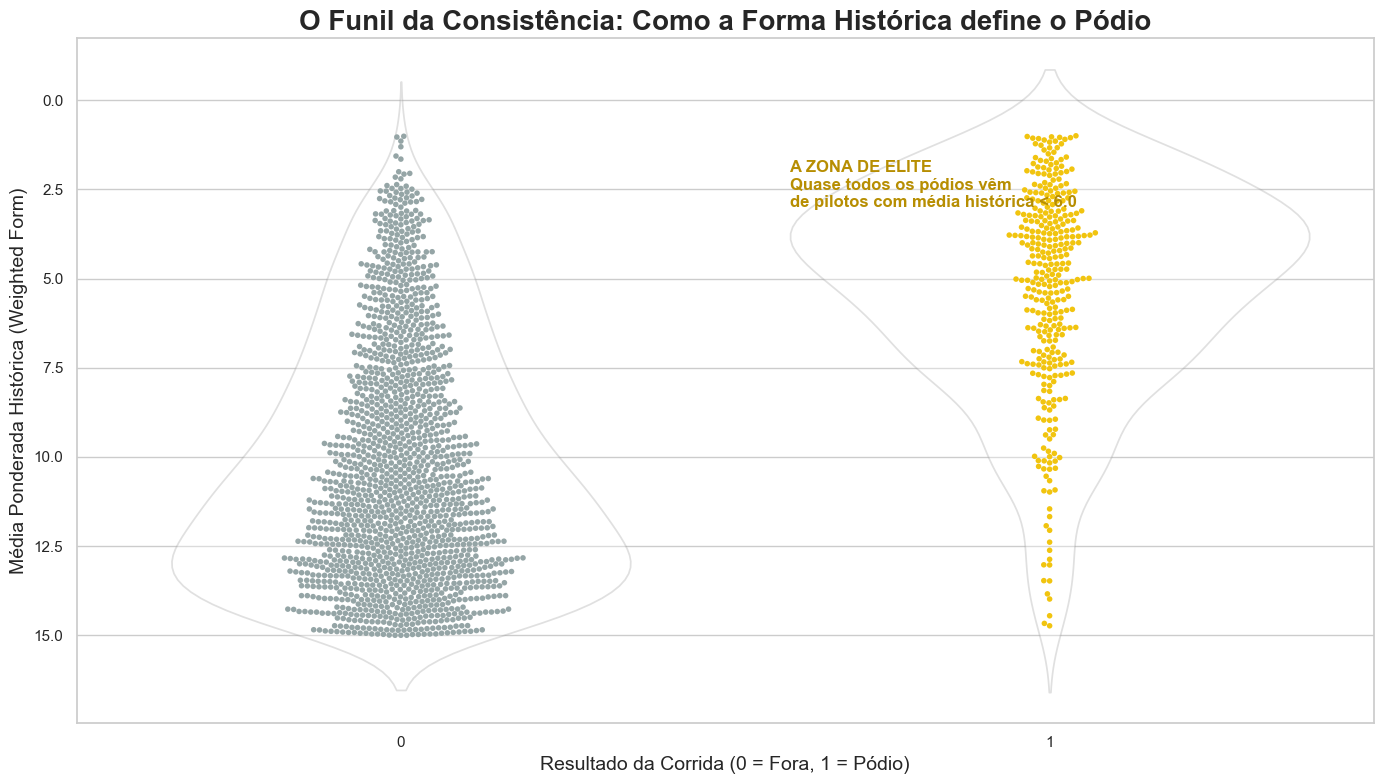

In [46]:
# ==========================================
# GRÁFICO 3: A NUVEM DE CONSISTÊNCIA (SWARM PLOT)
# Interação: Forma Ponderada vs Resultado Real
# ==========================================
plt.figure(figsize=(14, 8))

# Swarmplot mostra cada ponto de dado, ótimo para ver a "mancha" de probabilidade
# Filtramos outliers de forma ponderada muito alta para o gráfico ficar bonito
plot_data = df[df['weighted_avg_pos'] <= 15]

sns.swarmplot(x='podium', y='weighted_avg_pos', data=plot_data, size=4, palette=["#95a5a6", "#f1c40f"])

# Adicionar violino por trás para ver a densidade
sns.violinplot(x='podium', y='weighted_avg_pos', data=plot_data, inner=None, color="white", alpha=0.3)

plt.title('O Funil da Consistência: Como a Forma Histórica define o Pódio', fontsize=20, weight='bold')
plt.xlabel('Resultado da Corrida (0 = Fora, 1 = Pódio)', fontsize=14)
plt.ylabel('Média Ponderada Histórica (Weighted Form)', fontsize=14)
plt.gca().invert_yaxis() # Inverter porque média 1.0 é melhor que 10.0

# Anotação
plt.text(0.6, 3, "A ZONA DE ELITE\nQuase todos os pódios vêm\nde pilotos com média histórica < 6.0", 
         fontsize=12, color='#b78e02', weight='bold')

plt.tight_layout()
plt.show()

---

<Figure size 1400x800 with 0 Axes>

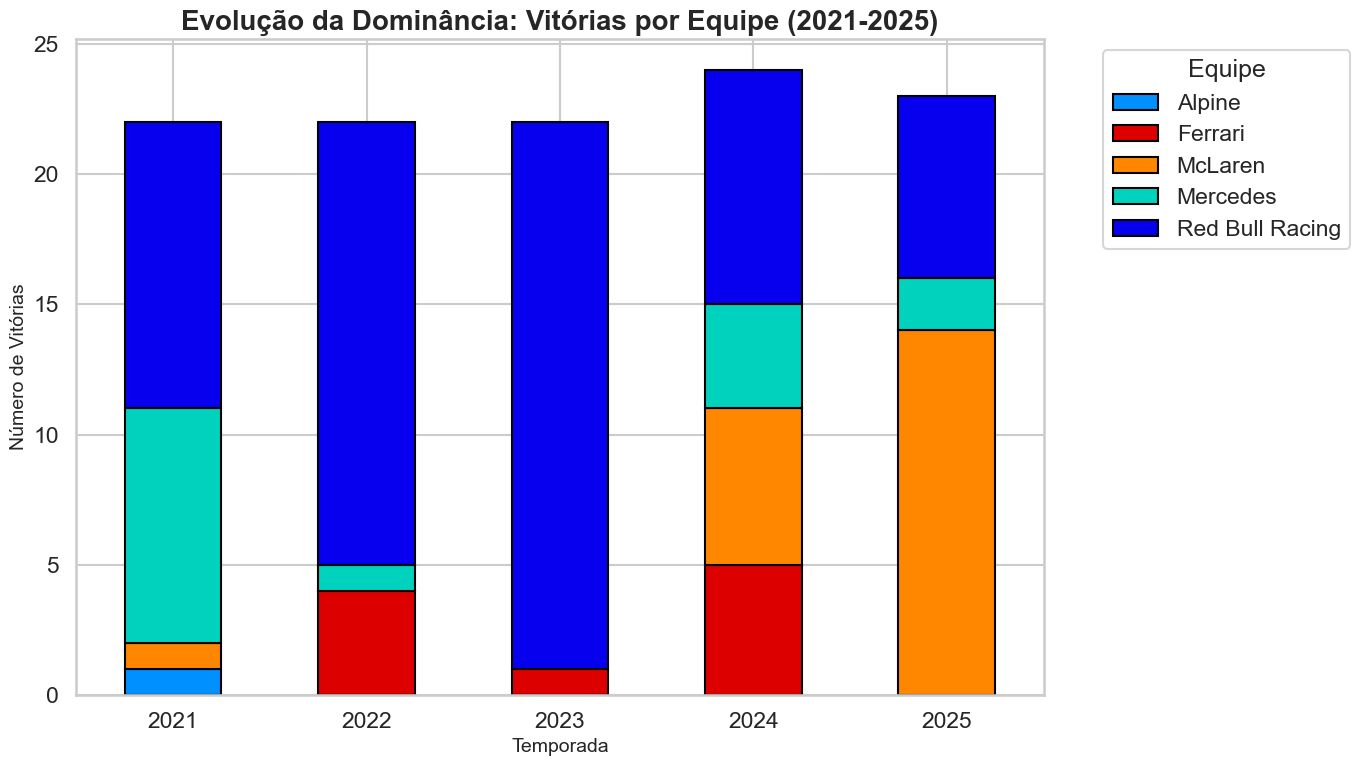

In [54]:
# Configuração Visual Limpa
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (16, 9)

# Cores Oficiais (Aproximadas) para facilitar a leitura
team_colors = {
    'Red Bull Racing': '#0600EF',
    'Ferrari': '#DC0000',
    'Mercedes': '#00D2BE',
    'McLaren': '#FF8700',
    'Aston Martin': '#006F62',
    'Alpine': '#0090FF',
    'Williams': '#005AFF',
    'AlphaTauri': '#2B4562',
    'RB': '#2B4562', # RB e AlphaTauri são a mesma linhagem
    'Haas F1 Team': '#FFFFFF',
    'Alfa Romeo': '#900000',
    'Kick Sauber': '#52E252',
    'Sauber': '#52E252'
}
# Fallback para cor cinza se a equipe não estiver na lista
default_color = '#7f8c8d'

# =========================================================
# GRÁFICO 1: DOMINÂNCIA (Vitórias por Temporada)
# =========================================================
plt.figure(figsize=(14, 8))

# Filtrar apenas vencedores
winners = df[df['final_position'] == 1]

# Contar vitórias por Ano e Equipe
wins_per_year = winners.groupby(['season', 'team_name']).size().unstack(fill_value=0)

# Plotar (Stacked Bar)
# Usamos as cores do dicionário, mapeando para as colunas presentes
colors_mapped = [team_colors.get(team, default_color) for team in wins_per_year.columns]
wins_per_year.plot(kind='bar', stacked=True, color=colors_mapped, figsize=(14, 8), edgecolor='black')

plt.title('Evolução da Dominância: Vitórias por Equipe (2021-2025)', fontsize=20, weight='bold')
plt.xlabel('Temporada', fontsize=14)
plt.ylabel('Número de Vitórias', fontsize=14)
plt.legend(title='Equipe', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\thzli\AppData\Local\Temp\ipykernel_5404\2012520174.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='team_name', y='final_position', data=df_top, order=my_order, palette=team_colors)


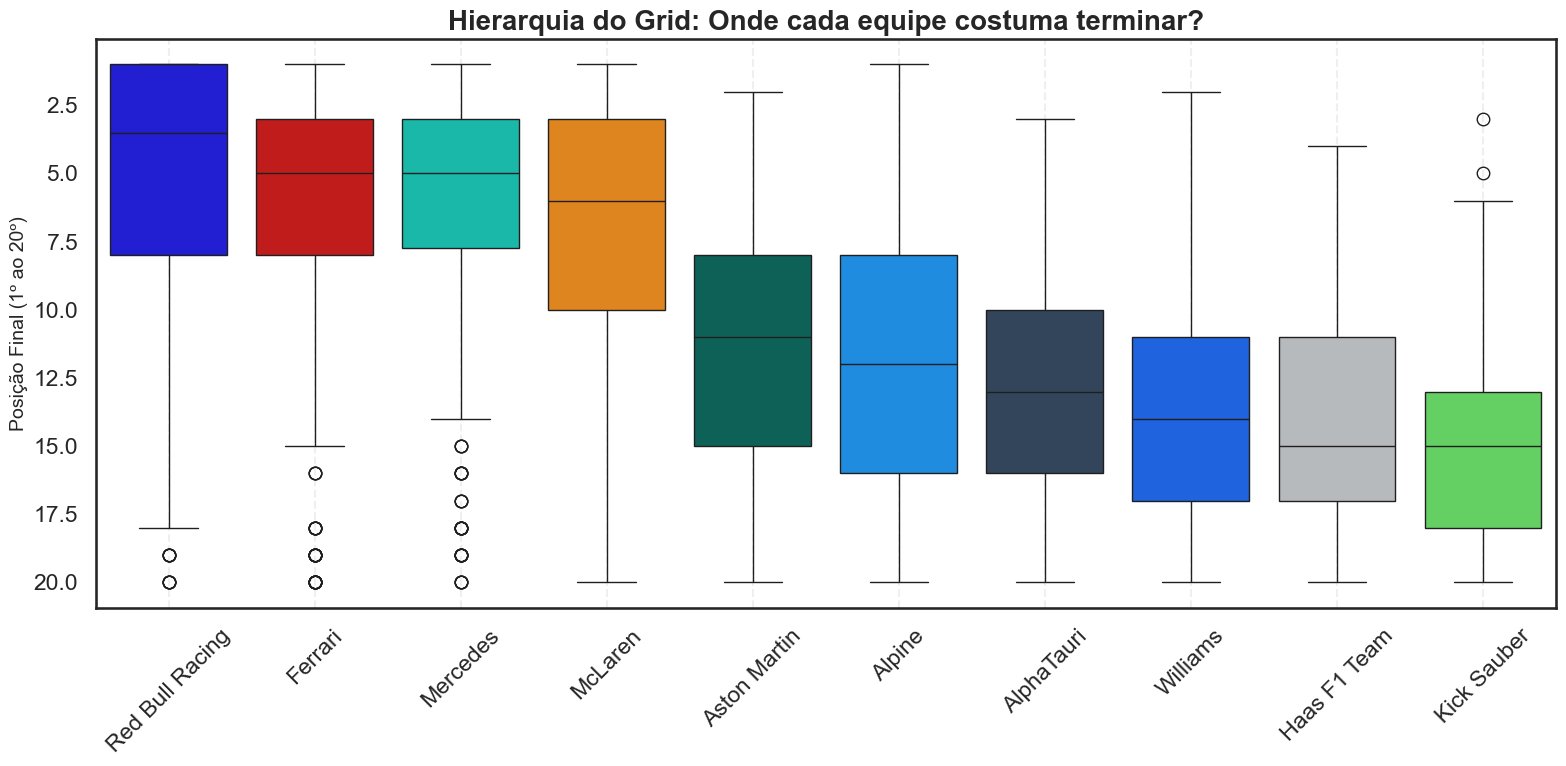

In [62]:
# =========================================================
# GRÁFICO 2: A HIERARQUIA (Performance Média por Equipe)
# =========================================================
plt.figure(figsize=(16, 8))

# Filtrar apenas equipes ativas/relevantes para não poluir
top_teams = df['team_name'].value_counts().index[:10]
df_top = df[df['team_name'].isin(top_teams)]

# Ordenar por mediana da posição final (Melhores equipes na esquerda)
my_order = df_top.groupby("team_name")["final_position"].median().sort_values().index

# Boxplot
sns.boxplot(x='team_name', y='final_position', data=df_top, order=my_order, palette=team_colors)

plt.title('Hierarquia do Grid: Onde cada equipe costuma terminar?', fontsize=20, weight='bold')
plt.ylabel('Posição Final (1º ao 20º)', fontsize=14)
plt.xlabel('')
plt.gca().invert_yaxis() # Inverter para o 1º ficar no topo
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

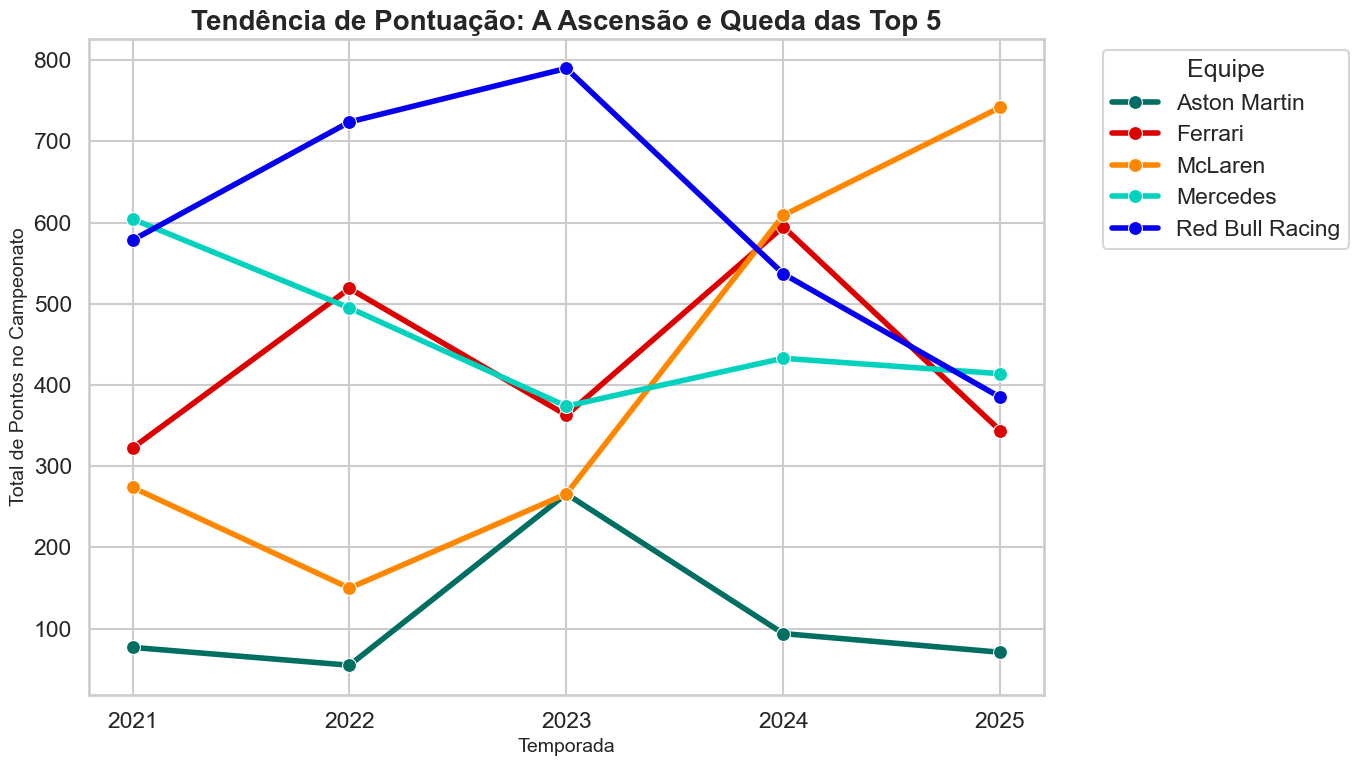

In [53]:
# =========================================================
# GRÁFICO 3: TENDÊNCIA DE PONTOS (Evolução Anual)
# =========================================================
plt.figure(figsize=(14, 8))

# Somar pontos por equipe e ano
season_points = df.groupby(['season', 'team_name'])['points'].sum().reset_index()

# Selecionar Top 5 equipes históricas para o gráfico de linhas não virar um espaguete
top_5_teams = season_points.groupby('team_name')['points'].sum().nlargest(5).index
season_points_filtered = season_points[season_points['team_name'].isin(top_5_teams)]

# Lineplot
sns.lineplot(data=season_points_filtered, x='season', y='points', hue='team_name', 
             palette=team_colors, linewidth=4, marker='o', markersize=10)

plt.title('Tendência de Pontuação: A Ascensão e Queda das Top 5', fontsize=20, weight='bold')
plt.xlabel('Temporada', fontsize=14)
plt.ylabel('Total de Pontos no Campeonato', fontsize=14)
plt.xticks(season_points['season'].unique()) # Garantir anos inteiros no eixo X
plt.legend(title='Equipe', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


---

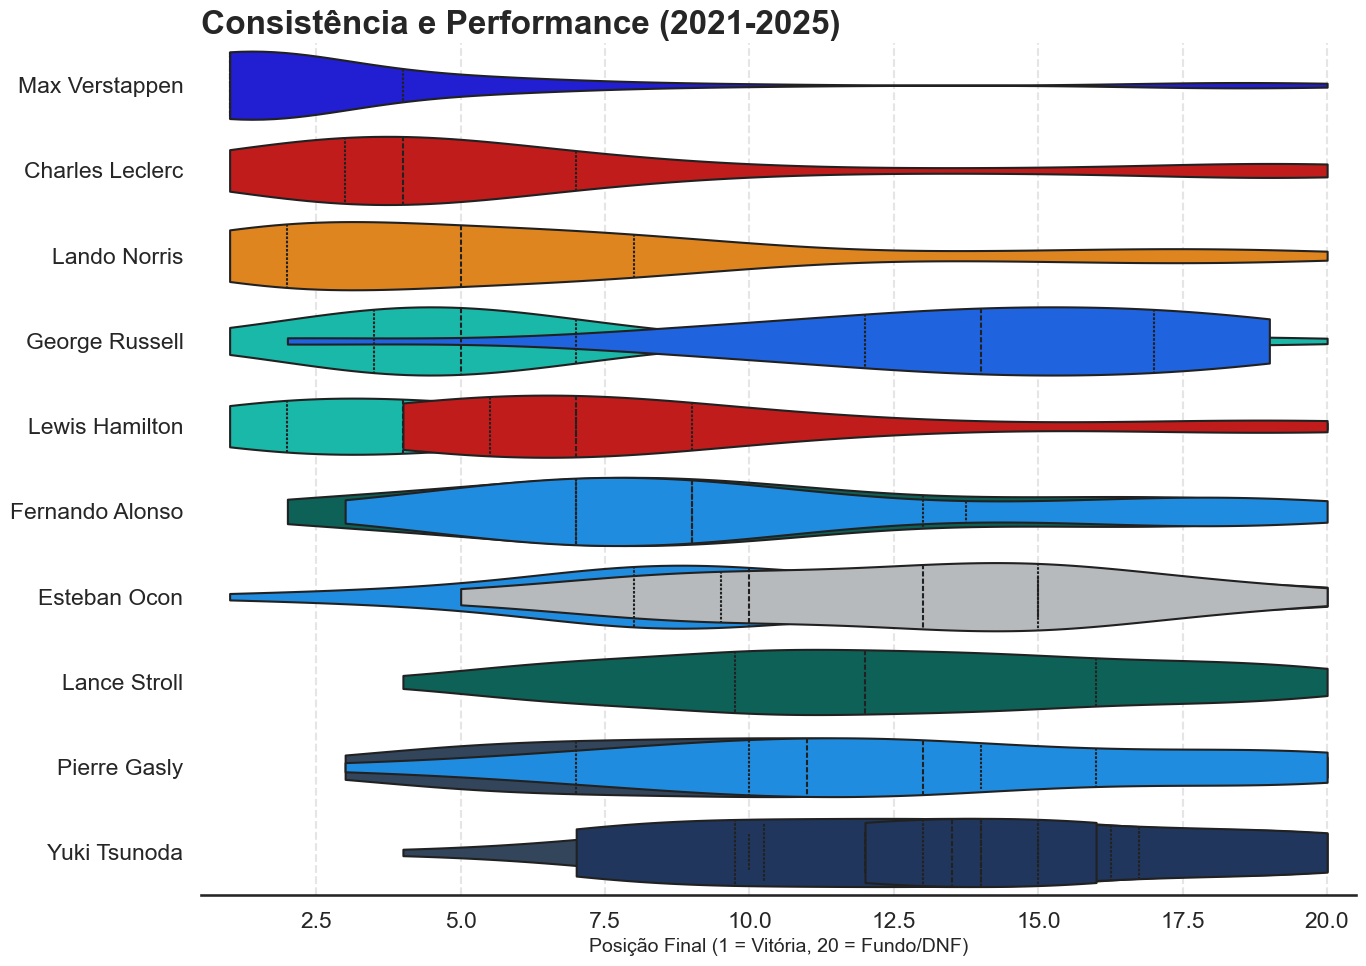

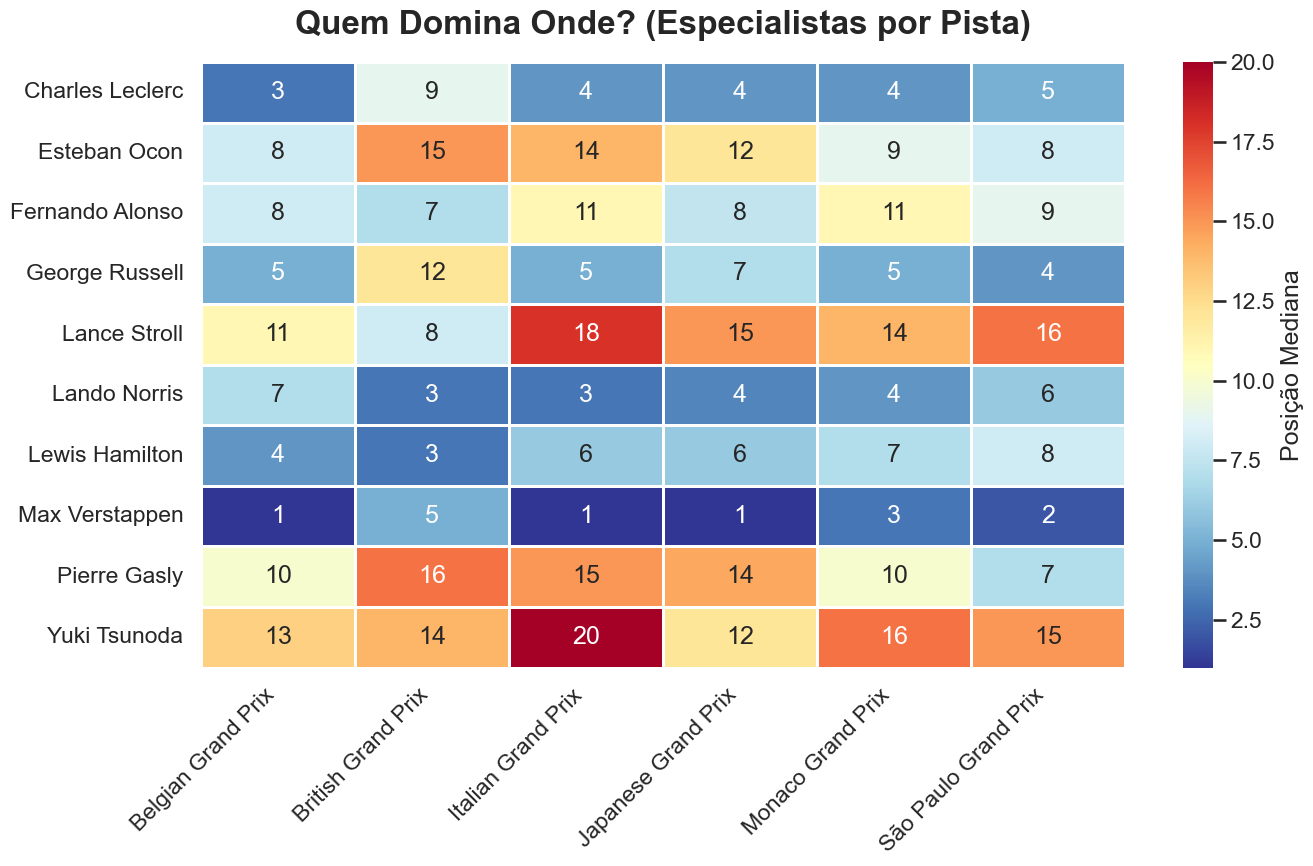

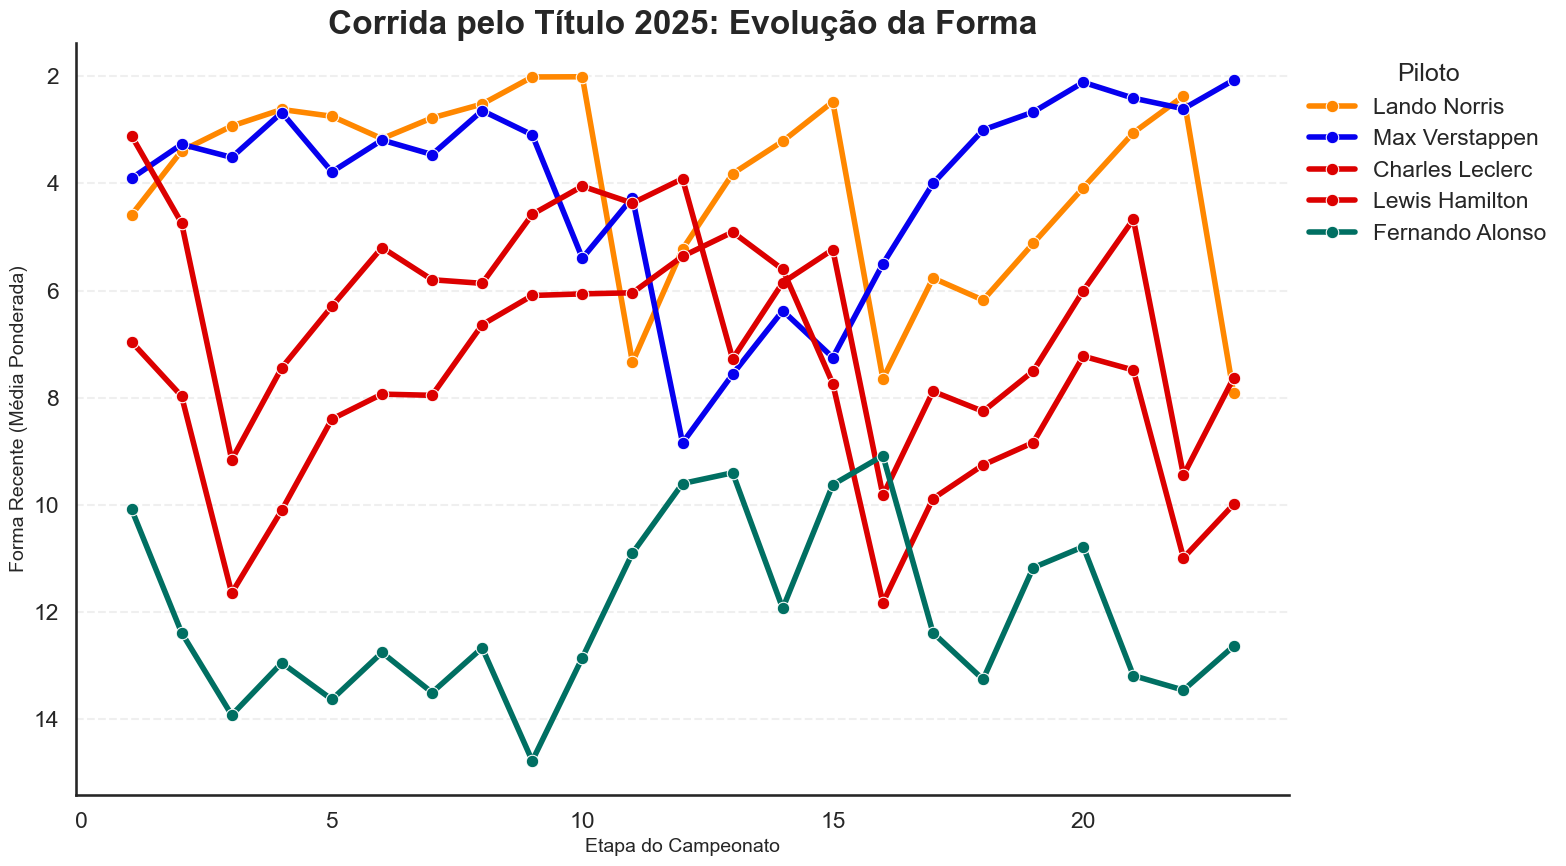

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURAÇÃO E PALETA ROBUSTA
# ==========================================
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (16, 10)

# Dicionário Base de Cores
base_team_colors = {
    'Red Bull Racing': '#0600EF', 'Ferrari': '#DC0000', 'Mercedes': '#00D2BE',
    'McLaren': '#FF8700', 'Aston Martin': '#006F62', 'Alpine': '#0090FF',
    'Williams': '#005AFF', 'Haas F1 Team': '#B6BABD', 
    'Alfa Romeo': '#900000', 'Alfa Romeo Racing': '#900000',
    'Kick Sauber': '#52E252', 'Sauber': '#52E252', 'Stake F1 Team Kick Sauber': '#52E252',
    'AlphaTauri': '#2B4562', 'Scuderia AlphaTauri': '#2B4562',
    'RB': '#163366', 'Racing Bulls': '#163366', 'Visa Cash App RB': '#163366'
}

# GARANTIA: Se o nome da equipe no dataset for estranho, usa cinza.
# Isso evita o gráfico em branco/erro.
unique_teams = df['team_name'].unique()
final_palette = base_team_colors.copy()
for team in unique_teams:
    if team not in final_palette:
        final_palette[team] = '#555555'

# =========================================================
# GRÁFICO 1: O "DNA" DA PERFORMANCE (VIOLIN PLOT)
# =========================================================
plt.figure(figsize=(14, 10)) # Aumentei a altura para caber os nomes

# 1. Filtrar Top 10 pilotos mais frequentes (pelo Nome)
top_drivers_names = df['driver_name'].value_counts().index[:10]
df_violin = df[df['driver_name'].isin(top_drivers_names)].copy()

# 2. Ordenar por Mediana da posição (Melhores no topo)
order = df_violin.groupby('driver_name')['final_position'].median().sort_values().index

# 3. Plotar usando 'driver_name' no eixo Y
sns.violinplot(
    data=df_violin, 
    x='final_position', 
    y='driver_name',      # <--- MUDANÇA AQUI (Nome Real)
    order=order,
    hue='team_name', 
    palette=final_palette, 
    inner='quart',
    linewidth=1.5,
    dodge=False,
    cut=0
)

plt.title('Consistência e Performance (2021-2025)', fontsize=24, weight='bold', loc='left')
plt.xlabel('Posição Final (1 = Vitória, 20 = Fundo/DNF)', fontsize=14)
plt.ylabel('', fontsize=12)
plt.xlim(0.5, 20.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Remover legenda (a cor já indica a equipe)
plt.legend([],[], frameon=False)
sns.despine(left=True)
plt.tight_layout()
plt.show()

# =========================================================
# GRÁFICO 2: A MATRIZ DE ESPECIALISTAS (HEATMAP)
# =========================================================
plt.figure(figsize=(14, 9))

iconic_tracks = ['Monaco Grand Prix', 'British Grand Prix', 'Italian Grand Prix', 
                 'Belgian Grand Prix', 'São Paulo Grand Prix', 'Japanese Grand Prix']

# Filtrar dados
df_tracks = df[df['event_name'].isin(iconic_tracks) & df['driver_name'].isin(top_drivers_names)]

# Pivot Table usando driver_name
track_matrix = df_tracks.pivot_table(index='driver_name', columns='event_name', values='final_position', aggfunc='median')

# Heatmap
sns.heatmap(
    track_matrix, 
    annot=True, 
    fmt=".0f", 
    cmap="RdYlBu_r", # Azul = Bom (Posição Baixa), Vermelho = Ruim
    linewidths=2, 
    linecolor='white',
    cbar_kws={'label': 'Posição Mediana'}
)

plt.title('Quem Domina Onde? (Especialistas por Pista)', fontsize=24, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =========================================================
# GRÁFICO 3: EVOLUÇÃO DA FORMA (LINHA DE TENDÊNCIA)
# =========================================================
plt.figure(figsize=(16, 9))

latest_season = df['season'].max()
top_5_names = top_drivers_names[:5] # Apenas Top 5 para não poluir
df_trend = df[(df['season'] == latest_season) & (df['driver_name'].isin(top_5_names))].copy()

# Paleta específica para as linhas dos pilotos
driver_palette = {}
for driver in df_trend['driver_name'].unique():
    team = df_trend[df_trend['driver_name'] == driver]['team_name'].iloc[0]
    driver_palette[driver] = final_palette.get(team, '#333333')

sns.lineplot(
    data=df_trend, 
    x='round', 
    y='weighted_avg_pos', 
    hue='driver_name',      # <--- MUDANÇA AQUI
    palette=driver_palette,
    linewidth=4,
    marker='o'
)

plt.title(f'Corrida pelo Título {latest_season}: Evolução da Forma', fontsize=24, weight='bold')
plt.ylabel('Forma Recente (Média Ponderada)', fontsize=14)
plt.xlabel('Etapa do Campeonato', fontsize=14)
plt.gca().invert_yaxis() # 1º lugar no topo
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Piloto', frameon=False)

sns.despine()
plt.tight_layout()
plt.show()

### Salvar base de features

In [73]:
# Lista das colunas essenciais para o modelo
cols_to_save = [
    # 1. IDENTIFICADORES (Contexto)
    'season', 
    'round', 
    'event_name', 
    'driver_name', 
    'team_name',     
    # 2. INPUTS DA CORRIDA ATUAL (O que sabemos antes da largada)
    'grid_position',  # A variável mais importante!
    
    # 3. FEATURES CALCULADAS (A "Inteligência" do passado)
    'podiums_last_5',       # Momentum
    'weighted_avg_pos',     # Forma Recente
    'team_podium_rate_5',   # Força do Carro
    'avg_racecraft',        # Habilidade de recuperação
    'reliability_rate',     # Segurança/Risco
    'track_avg_pos',        # Especialista na pista
    
    # 4. TARGET (O que queremos prever - Para treino)      # Posição exata (útil para regressão ou referência)
    'podium'      # O alvo final (0 ou 1)
]

# Criar o dataframe 
df_model_ready = df[cols_to_save].copy()

# Remover linhas com NaNs (geralmente as primeiras corridas da carreira do piloto)
df_model_ready = df_model_ready.dropna()

# Salvar
df_model_ready.to_csv('f1_model_training_data.csv', index=False)

print(f"Dataset salvo com sucesso! Dimensões: {df_model_ready.shape}")
print("Colunas incluídas:")
print(df_model_ready.columns.tolist())

Dataset salvo com sucesso! Dimensões: (2086, 13)
Colunas incluídas:
['season', 'round', 'event_name', 'driver_name', 'team_name', 'grid_position', 'podiums_last_5', 'weighted_avg_pos', 'team_podium_rate_5', 'avg_racecraft', 'reliability_rate', 'track_avg_pos', 'podium']


In [67]:
df.columns

Index(['season', 'round', 'event_name', 'location', 'event_date',
       'driver_code', 'driver_number', 'driver_name', 'team_name',
       'grid_position', 'final_position', 'status', 'points', 'total_time_sec',
       'fastest_lap_time_sec', 'laps_completed', 'avg_lap_time_sec',
       'best_lap_time_sec', 'std_lap_time_sec', 'clean_avg_lap_time_sec',
       'n_pitstops', 'total_pit_time_sec', 'n_stints', 'compounds_used',
       'podium', 'podiums_last_5', 'weighted_avg_pos', 'pos_gain_raw',
       'avg_racecraft', 'is_finished', 'reliability_rate', 'track_avg_pos',
       'Grid_Cat'],
      dtype='object')